# **Automated Radiology Report Generation using Vision-Language Model**

- Yuting Fang (z5518340)
- Lingxiao Jiang (z5562632)
- Peidong Liang (z5603156)
- Jiabei Wu (z5597215)
- Zhiwei Guo (z5550962)

# **1. Introduction**

### **1.1 Background**
In recent decades, the field of radiological imaging has undergone revolutionary changes, making the accurate and efficient interpretation of medical images crucial in modern diagnostics. The generation of radiology reports, to automatically produce free-text descriptions for clinical radiographs (e.g. chest X-rays), has emerged as a compelling research direction in the domains of artificial intelligence and clinical medicine. It can considerably expedite the automation of workflows and enhance the quality and standardization of healthcare.

Recent advancements in vision-language models (VLMs) have significantly accelerated progress in this area. Foundation models have driven revolutionary advancements in complex multimodal applications, in which VLMs focus on integrating visual and language modalities. By leveraging paired datasets during pre-training, models such as CLIP align images with text, making them highly effective for tasks requiring multimodal reasoning

### **1.2 Motivation**
Based on the above background, considerable scope exists for enhancement in the implementing of AI in this field. Recent breakthroughs in multimodal foundation models have demonstrated that AI systems trained on a vast quantity of unlabeled data can be adapted and achieve state-of-the-art accuracy in a wide range of downstream specialized tasks, including biomedical problems. There are numerous issues that require further investigation and resolution.

### **1.3 Purpose**
Develop an automated system that generates full radiology reports from chest X-ray images, using data consistent with the MIMIC-CXR-JPG. The main object is to automate the reporting process while maintaining high accuracy and clinical relevance. We adopt a transformer-based vision–language framework with a BERT-style architecture. The system couples an image encoder with a language decoder to translate visual findings into structured narrative reports.

We will start from the MedViLL (BERT-based), which is obtained from the article (https://doi.org/10.1109/JBHI.2022.3207502), design and tweak its components to better suit our data and objectives. Also, we will use the model MedViLL as our baseline to evaluate the performance of our models.

### **1.4 Contribution**

The development process involved the creation of six model variants, with the foundation being the BERT-style Medical Vision Language Learner (MedViLL), which has undergone pre-training on chest X-ray datasets. In the proposed framework, the original computer vision is substituted with three distinct vision models, namely CheXNet, ResNet101, and Vision Transformer (ViT), while the decoder from Clinical T5 is adopted for the generation of diagnostic text. We named the part including BERT-encoder and Clinical T5 decoder as RadScribe. Furthermore, an investigation is conducted into a label-enhanced approach, whereby clinical labels are extracted from the ground truth reports, which are utilized to train a classifier. Then, we integrate the label we get from the classifier with the vectorized images by cross-attention. The experimental results demonstrate that the models with a label-enhanced approach outperform other models, and the ViT-Label-RadScribe configuration outperforms all other variants and achieves better performance than the baseline MedViLL model.

In short, we have six different models:

- CheXNet-RadScribe
- CheXNet-RadScribe
- ResNet101-RadScribe
- ResNet101-Label-RadScribe
- ViT-RadScribe
- Vit-Label-BERT_T5

# **2. Data Processing**

## **2.1 Data Source**

This study utilizes a curated training subset of the MIMIC-CXR v2.0 dataset, a large-scale, publicly available collection of chest radiographs paired with free-text radiology reports. The full dataset contains approximately 330,000 de-identified chest X-ray images and over 220,000 associated radiology reports, collected at the Beth Israel Deaconess Medical Center between 2011 and 2016.  

For computational efficiency and to facilitate model development, we selected a representative subset of approximately 10,000 image–report pairs for training. This subset preserves the diversity of imaging views (primarily posteroanterior and lateral) and clinical findings, ensuring that the reduced data volume still supports effective supervised learning.


——————————————DATA INSTANCE——————————————

Each data instance in the dataset comprises a pair of medical images and a corresponding free-text report, enabling supervised training for the radiology report generation task. Specifically:

- **Finding Example:**  
  `There is mild prominence of bilateral bronchovascular markings, suggestive of chronic small airway disease. A faint patchy opacity is noted in the left lower lung zone, which may represent early inflammatory change. The cardiomediastinal silhouette is slightly enlarged but maintains a normal contour. The costophrenic angles remain sharp bilaterally. No pneumothorax or large pleural effusion is identified. The bony thorax is intact without acute fracture or destructive lesion.`
- **Image Example:**

<table>
  <tr>
    <th style="text-align:center;">PA View (Frontal)</th>
    <th style="text-align:center;">Lateral View</th>
  </tr>
  <tr>
    <td align="center"><img src="./imgs/CXR4_IM-2050-1001-PA.png" width="350"></td>
    <td align="center"><img src="./imgs/CXR4_IM-2050-1001-LV.png" width="350"></td>
  </tr>
  <tr>
    <td align="center"><em>Figure 1: Posteroanterior (PA) Projection</em></td>
    <td align="center"><em>Figure 2: Lateral Projection</em></td>
  </tr>
</table>



## **2.2 Challenge Aspects**

---

### **Challenge 1: Dataset Scale Too Large**
**Background**  
The MIMIC-CXR dataset contains over 300,000 chest X-ray images and more than 200,000 medical reports.  

**Problem**  
Training directly on the full dataset would require excessive computational resources, prolonged training time, and significant storage capacity.  

<p align="center">
  <img src="./imgs/pic1.png" alt="Dataset scale illustration" width="600">
</p>
<p align="center"><em>Figure: Illustration of dataset scale and complexity</em></p>

**Impact**
- Higher GPU/CPU workload and longer training cycles  
- Increased memory and disk usage  
- Reduced experiment iteration speed  

**Solution**
- Selected an official MIMIC-CXR subset (~10,000 images) to reduce computation and storage needs.  
- The subset still maintained good representativeness, achieving strong model performance.

---

### **Challenge 2: Large Number of Abnormal Images**
**Background**  
Due to varying imaging devices, hospitals, and acquisition conditions, the dataset inevitably contains abnormal images (e.g., all-black, all-white, blurred, black borders, text overlays, ghosting/artifacts).  

**Problem**  
If these abnormal images are not filtered, they waste computational resources and introduce noise into model training.  

<p align="center">
  <img src="./imgs/pic2.png" width="400">
  <img src="./imgs/pic3.png" width="400">
</p>
<p align="center"><em>Figure: Examples of abnormal images (Ghosting and Blurred)</em></p>

**Impact**
- Slower convergence due to noisy training data  
- Poor feature extraction quality  

**Solution**
- Applied automated anomaly detection:  
  - **Pixel analysis**: Removed all-black (mean < 15, std < 10) and all-white (mean > 240, std < 10) images  
  - **Laplacian variance**: Removed blurred images (variance < 20)  
  - **OCR detection**: Removed images with >15% area covered by text  
  - **High-frequency gradient analysis**: Removed ghosting/artifact images (>35% of pixels affected)  
- Retained ~10,000 high-quality images for efficient and stable training.  

<p align="center">
  <img src="./imgs/pic4.png" width="600">
</p>
<p align="center"><em>Figure: Filtering criteria and thresholds for detecting abnormal images</em></p>

---

### **Challenge 3: Information Loss During Format Conversion**
**Background**  
Original reports in XML format were converted to CSV and then to JSONL for model input.  

**Problem**  
Multi-step conversions may cause data loss, such as truncated text, missing special characters, or loss of structural information.  

**Impact**
- Incomplete clinical descriptions  
- Decreased report generation accuracy and interpretability  

**Solution**
- Enforced UTF-8 encoding and used robust XML parsers (`lxml`/`ElementTree`)  
- Added field length and missing value checks during conversion  
- Considered direct XML → JSONL conversion to avoid intermediate losses  

---

### **Challenge 4: Data and Label Misalignment**
**Background**  
The labeled dataset requires accurate pairing between each image and its structured labels (e.g., disease category, location annotations).  

**Problem**  
MIMIC-CXR has a complex mapping between reports and images (one-to-many or many-to-many relationships), making pairing error-prone.  

**Impact**
- Label noise that misguides the model during training  

**Solution**
- Verified both **UID** and **Image Name** in pairing  
- Built a hash mapping (image_path → label_id) and performed consistency checks  
- Randomly spot-checked samples for correctness

---

### **Challenge 5: Imbalanced Label and Text Distribution**
**Background**  
The MIMIC-CXR dataset contains a wide range of medical labels and free-text radiology reports. However, both label and text distributions are highly imbalanced:  
- A small number of labels and medical terms appear disproportionately often.  
- Many rare labels and terms occur infrequently, providing limited training examples.  
- The lengths of reports vary significantly, which can introduce challenges for sequence modeling.  

These imbalances can bias the model toward over-represented patterns and reduce performance on under-represented findings.

**Problem**  
- Imbalanced label frequencies cause the model to favor common diagnoses while neglecting rare but clinically important conditions.  
- Skewed medical term frequencies limit vocabulary diversity in generated reports.  
- Large variance in text length makes it harder for the model to learn consistent representations.  

#### **Label Distribution Analysis**
<p align="center">
  <img src="./imgs/pic6.png" width="900">
</p>
<p align="center"><em>Figure 1: Distribution of medical labels across samples in MIMIC-CXR dataset.</em></p>

#### **Medical Terms Analysis**
<p align="center">
  <img src="./imgs/pic7.png" width="900">
</p>
<p align="center"><em>Figure 2: Frequency, density, and type distribution of medical terms in radiology reports.</em></p>

#### **Text Length Analysis**
<p align="center">
  <img src="./imgs/pic8.png" width="900">
</p>
<p align="center"><em>Figure 3: Distribution of character count, word count, token count, and their comparative statistics in reports.</em></p>

**Impact**  
- Over-represented labels dominate model learning, causing poor generalization to rare findings.  
- Frequent medical terms appear correctly in outputs, but rare terms are often missed.  
- Reports with extreme lengths can degrade performance in sequence-to-sequence learning models.

**Solution**  
- Applied label balancing techniques, such as weighted loss functions and oversampling for rare labels.  
- Augmented rare-term reports using synonym replacement and paraphrasing to improve term coverage.  
- Normalized report length by truncating overly long reports and padding short ones to stabilize training.

---

### **Challenge 6: Underperformance of Non-Labeled Model**
**Background**  
Two dataset versions were used:

- Image-to-text (no label)  
- Image + label-to-text (with label)  

The labeled version significantly outperformed the non-labeled one.

**Problem**  
Without label supervision, the model has weaker semantic control and lower generalization in multi-task settings.

**Impact**
- More vague outputs and reduced factual accuracy in generated reports  

**Solution**
- Added weak labels for the unlabeled set (via rules, keyword matching, or pre-trained models)  
- Introduced multi-task learning for classification + generation  
- Applied contrastive learning to strengthen semantic representations  

<p align="center">
  <img src="./imgs/pic5.png" width="600">
</p>
<p align="center"><em>Figure: Performance comparison between non-labeled and labeled model versions</em></p>

---

### **Challenge 7: Train/Validation Distribution Mismatch**
**Background**  
- **Train_10000.jsonl**: 10,000 image–report pairs for supervised training  
- **Valid_500.jsonl**: 500 image–report pairs with labels for BLEU/ROUGE/BERTScore evaluation  

**Problem**  
If the distribution of images and reports in the train set differs significantly from the validation set (e.g., disease types, imaging angles, modality proportion), evaluation results may not accurately reflect true model performance.  

**Impact**
- Misleading evaluation metrics  
- Incorrect hyperparameter tuning decisions  

**Solution**
- Applied stratified sampling to maintain label distribution consistency  
- Conducted statistical comparison between training and validation sets  
- Used multiple validation sets or cross-validation for more robust evaluation

## **2.3 Pre-processing**

In [ ]:
def worker_init_fn(worker_id):
    worker_info = get_worker_info()
    dataset = worker_info.dataset
    dataset.proc.tar = tarfile.open(dataset.proc.img_archive, mode="r:gz")


def get_random_word(vocab_words):
    i = randint(0, len(vocab_words) - 1)
    return vocab_words[i]


def batch_list_to_batch_tensors(batch):
    batch_tensors = []
    for x in zip(*batch):
        if isinstance(x[0], torch.Tensor):
            batch_tensors.append(torch.stack(x))
        else:
            batch_tensors.append(torch.tensor(x, dtype=torch.long))
    return batch_tensors


class Pipeline:
    """Pre-process Pipeline Class : callable"""

    def __init__(self):
        super().__init__()
        self.mask_same_word = None
        self.skipgram_prb = None
        self.skipgram_size = None

    def __call__(self, instance):
        raise NotImplementedError


if __name__ == "__main__":
    pass




### **2.3.1 What are we doing (Without input label)**

This code defines a custom PyTorch `Dataset` class (`Img2txtDataset`) and an associated preprocessing pipeline (`PreprocessSeq2seqGen`) for radiology report generation without structured labels. Each instance consists of:

- A chest X-ray image path
- Its associated free-text radiology report

The core objective is to support image-to-text (vision-to-language) generation by preparing the inputs required for multimodal transformer models in a label-free setting.

The dataset is parsed as image–text pairs, and the pipeline:
- Loads and normalizes the image
- Tokenizes the report using BERT and T5 tokenizers
- Builds encoder inputs (`input_ids`, `segment_ids`, `attention_mask`)
- Constructs decoder targets (`t_b`) with padding
- Outputs a tuple ready for training (vision, language, and alignment)


### **2.3.2 Why we did so**

1. No structured labels in clinical datasets
    reason: Most real-world medical datasets like MIMIC-CXR contain image–report pairs but no formal structured labels. Thus, generating radiology reports directly from images (without supervised categories) mimics realistic clinical applications.

3. Flexible, general-purpose image-text representation
    reason: The tuple `(img_path, text)` enables training in a wide range of vision-language tasks, such as captioning, report generation, or contrastive learning. We use this to prepare inputs suitable for transformer architectures.

4. Encoder–decoder friendly token construction  
    reason: BERT-based tokenization is used for building the encoder sequence, while T5 tokenization creates decoder labels (`t_b`). This enables compatibility with models like ClinicalT5 or METransformer.

5. Image preprocessing into visual tokens
    reason: The grayscale image is resized, normalized, and converted to a tensor to ensure consistent format and scale. These serve as visual embeddings in multimodal fusion layers.

7. Attention mask for cross-modal alignment
    reason: A custom attention mask matrix ensures that visual tokens can attend to the correct parts of the input and that text can be properly decoded. This facilitates smooth multimodal training without requiring explicit alignment labels.

9. Padding and truncation for sequence consistency
    reason: Sequences shorter than maximum length are padded, and those exceeding the limit are truncated to prevent dimension mismatch or memory overflow. This ensures stable training in batch settings.


This implementation allows the model to learn cross-modal mappings from image to report in a weakly supervised or unsupervised manner, which is especially important in medical domains where labeled data is expensive and limited.


In [ ]:
class Img2txtDataset(Dataset):
    def __init__(
        self,
        configs,
        bert_tokenizer,
        t5_tokenizer,
        data_set_path=None,
        img_archive=None,
    ):
        super().__init__()
        assert data_set_path is not None
        self.configs = configs
        self.max_seq_len = configs["max_seq_len"]
        self.bert_tokenizer = bert_tokenizer
        self.t5_tokenizer = t5_tokenizer

        # self.tar = tarfile.open(img_archive, mode='r:gz')
        self.tar = None

        img_dat = [json.loads(l) for l in open(data_set_path, "r", encoding="utf-8")]

        self.ex_list = [(d["img"], d["text"]) for d in img_dat]

        # preprocess pipeline
        self.proc = PreprocessSeq2seqGen(
            configs=configs,
            bert_tokenizer=bert_tokenizer,
            t5_tokenizer=t5_tokenizer,
            img_archive=img_archive,
            root_prefix="data/preprocessed/mimic/",
        )

    def __len__(self):
        return len(self.ex_list)

    def __getitem__(self, idx):
        return self.proc(self.ex_list[idx])


def truncate_tokens_pair(
    tokens_a,
    tokens_b,
    max_seq_len,
    max_len_a=0,
    max_len_b=0,
    trunc_seg=None,
    always_truncate_tail=False,
):
    num_truncated_a = [0, 0]
    num_truncated_b = [0, 0]
    while True:
        if len(tokens_a) + len(tokens_b) <= max_seq_len:
            break
        if (max_len_a > 0) and len(tokens_a) > max_len_a:
            trunc_tokens = tokens_a
            num_truncated = num_truncated_a
        elif (max_len_b > 0) and len(tokens_b) > max_len_b:
            trunc_tokens = tokens_b
            num_truncated = num_truncated_b
        elif trunc_seg:
            # truncate the specified segment
            if trunc_seg == "a":
                trunc_tokens = tokens_a
                num_truncated = num_truncated_a
            else:
                trunc_tokens = tokens_b
                num_truncated = num_truncated_b
        else:
            # truncate the longer segment
            if len(tokens_a) > len(tokens_b):
                trunc_tokens = tokens_a
                num_truncated = num_truncated_a
            else:
                trunc_tokens = tokens_b
                num_truncated = num_truncated_b
        # whether always truncate source sequences
        if (not always_truncate_tail) and (rand() < 0.5):
            del trunc_tokens[0]
            num_truncated[0] += 1
        else:
            trunc_tokens.pop()
            num_truncated[1] += 1
    return num_truncated_a, num_truncated_b


class PreprocessSeq2seqGen(Pipeline):
    def __init__(
        self,
        configs,
        bert_tokenizer,
        t5_tokenizer,
        img_archive: tarfile.TarFile,
        root_prefix: str,
    ):
        super().__init__()
        self.configs = configs
        self.bert_tokenizer = bert_tokenizer
        self.t5_tokenizer = t5_tokenizer

        self.img_archive = img_archive
        self.root_prefix = root_prefix.rstrip("/") + "/"

        self.max_seq_len = configs["max_seq_len"]  # maximum length of tokens
        self.len_vis_input = configs["num_image_embeds"]  # number of visual tokens
        self.seq_len = configs["seq_len"]  # maximum length of text tokens

        self.img_size = configs["img_size"]  # image size for resizing

        # image preprocessing
        self.gray3 = transforms.Grayscale(num_output_channels=3)
        self.resize = transforms.Resize(self.img_size)
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(
            mean=[0.492, 0.493, 0.494], std=[0.293, 0.293, 0.293]
        )

    def __call__(self, instance):
        # img_path, text_b = instance
        full_img_path, text_b = instance
        member_path = full_img_path.replace(self.root_prefix, "", 1)

        tokens_b_bert = self.bert_tokenizer.tokenize(text_b)

        if self.tar is None:
            self.tar = tarfile.open(self.img_archive, mode="r:gz")

        member = self.tar.getmember(member_path)
        f = self.tar.extractfile(member)
        img = Image.open(BytesIO(f.read())).convert("RGB")

        if len(tokens_b_bert) > self.max_seq_len:
            tokens_b_bert = tokens_b_bert[-self.max_seq_len :]

        # build text tokens input_ids
        input_ids = len(tokens_b_bert) * ["[PAD]"] + ["[SEP]"]  # len(seq_len) + [SEP]

        if len(input_ids) < self.seq_len + 1:  # +1 for [SEP]
            pad_len = self.seq_len - len(input_ids) + 1
            input_ids.extend(["[PAD]"] * pad_len)
        else:
            input_ids = input_ids[: self.seq_len + 1]

        input_ids = self.bert_tokenizer.convert_tokens_to_ids(input_ids)
        input_ids = torch.tensor(input_ids, dtype=torch.long)

        # build segment_ids [ seq_len + [SEP] ]
        segment_ids = [1 for _ in range(len(input_ids))]

        if len(segment_ids) < self.seq_len + 1:  # +1 for [SEP]
            segment_pad = self.seq_len + 1 - len(segment_ids)
            segment_ids.extend([0] * segment_pad)

        segment_ids = torch.tensor(segment_ids, dtype=torch.long)

        total = 1 + self.len_vis_input + 1 + self.seq_len + 1
        # build encoder input mask
        attn_mask = torch.zeros(total, total, dtype=torch.long)
        attn_mask[: self.len_vis_input + 2, :] = 1

        # image preprocessing
        # img = Image.open(img_path)
        img = self.gray3(img)
        img = self.resize(img)
        img = self.to_tensor(img)
        img = self.normalize(img)

        if isinstance(text_b, str) and text_b:
            t_b = self.t5_tokenizer.encode(
                text_b,
                add_special_tokens=True,
                max_length=512,
                truncation=True,
            )
        else:
            t_b = []
        if len(t_b) < 512:
            t_b.extend([self.t5_tokenizer.pad_token_id] * (512 - len(t_b)))

        t_b = torch.tensor(t_b, dtype=torch.long)

        cls_tok = torch.tensor(self.bert_tokenizer.convert_tokens_to_ids(["[CLS]"]))
        sep_tok = torch.tensor(self.bert_tokenizer.convert_tokens_to_ids(["[SEP]"]))

        return cls_tok, sep_tok, input_ids, segment_ids, attn_mask, img, t_b


if __name__ == "__main__":
    pass

### **2.3.3 What are we doing (Coding With Input Label)**

In this version, we extend the basic image-to-text dataset pipeline by incorporating structured labels alongside each image-report pair. These labels typically correspond to radiological findings (e.g., "Cardiomegaly", "Consolidation") extracted from the dataset.

The pipeline is designed to:
- Load an image, free-text report, and an optional classification label
- Encode the label into the encoder input sequence
- Generate the attention mask that conditions the decoder on both the label and visual features
- Output the full data tuple: label-enhanced encoder input, image tensor, and tokenized report

This enhancement allows the model to receive both label guidance and image cues when generating the report.

### **2.3.4 Why we did so**

1. To incorporate weak supervision from structured findings
    reason: Many datasets contain structured labels (e.g., from CheXpert, RadGraph) alongside free-text reports. By incorporating these as part of the encoder input, we enable guided generation, where the label acts as a form of high-level semantic constraint.

3. To improve content relevance and reduce hallucination
    reason: In medical report generation, models often generate clinically plausible but incorrect statements ("hallucinations"). Including ground-truth findings as part of the encoder input mitigates this risk by anchoring generation to known conditions.

5. To support hybrid multi-task training
    reason: This design allows the architecture to scale toward multi-task setups—for example, classification + generation—using shared components. Encoding labels aligns with pretraining objectives like masked language modeling with tag prompts.

7. To enhance attention control across modalities
    reason: The attention mask is dynamically constructed to allow the model to focus on both visual features and label tokens before decoding. This ensures coherent information flow, especially in transformers that require position-sensitive input control.

9. To retain backward compatibility with label-free settings
    reason: When no label is available or when label == 'No Finding', the pipeline defaults to padding with [PAD] tokens. This allows flexible deployment across datasets with or without structured annotation.

This preprocessing design enables label-informed vision-language generation, which is particularly valuable for tasks like condition-aware reporting, template-guided generation, or semi-supervised fine-tuning in clinical NLP settings.


In [ ]:
class Img2txtDatasetWithLabel(Dataset):
    def __init__(
        self,
        configs,
        bert_tokenizer,
        t5_tokenizer,
        data_set_path=None,
        img_archive=None,
    ):
        super().__init__()
        assert data_set_path is not None
        self.configs = configs
        self.max_seq_len = configs["max_seq_len"]
        self.bert_tokenizer = bert_tokenizer
        self.t5_tokenizer = t5_tokenizer

        # self.tar = tarfile.open(img_archive, mode='r:gz')
        self.tar = None

        img_dat = [json.loads(l) for l in open(data_set_path, "r", encoding="utf-8")]

        self.ex_list = [(d["img"], d["text"], d.get("label", "")) for d in img_dat]

        # preprocess pipeline
        self.proc = PreprocessSeq2seqGen(
            configs=configs,
            bert_tokenizer=bert_tokenizer,
            t5_tokenizer=t5_tokenizer,
            img_archive=img_archive,
            root_prefix="data/preprocessed/mimic/",
        )

    def __len__(self):
        return len(self.ex_list)

    def __getitem__(self, idx):
        return self.proc(self.ex_list[idx])

    def __del__(self):
        """确保在对象销毁时关闭打开的tar文件"""
        if (
            hasattr(self, "proc")
            and self.proc
            and hasattr(self.proc, "tar")
            and self.proc.tar
        ):
            self.proc.tar.close()


def truncate_tokens_pair(
    tokens_a,
    tokens_b,
    max_seq_len,
    max_len_a=0,
    max_len_b=0,
    trunc_seg=None,
    always_truncate_tail=False,
):
    num_truncated_a = [0, 0]
    num_truncated_b = [0, 0]
    while True:
        if len(tokens_a) + len(tokens_b) <= max_seq_len:
            break
        if (max_len_a > 0) and len(tokens_a) > max_len_a:
            trunc_tokens = tokens_a
            num_truncated = num_truncated_a
        elif (max_len_b > 0) and len(tokens_b) > max_len_b:
            trunc_tokens = tokens_b
            num_truncated = num_truncated_b
        elif trunc_seg:
            # truncate the specified segment
            if trunc_seg == "a":
                trunc_tokens = tokens_a
                num_truncated = num_truncated_a
            else:
                trunc_tokens = tokens_b
                num_truncated = num_truncated_b
        else:
            # truncate the longer segment
            if len(tokens_a) > len(tokens_b):
                trunc_tokens = tokens_a
                num_truncated = num_truncated_a
            else:
                trunc_tokens = tokens_b
                num_truncated = num_truncated_b
        # whether always truncate source sequences
        if (not always_truncate_tail) and (rand() < 0.5):
            del trunc_tokens[0]
            num_truncated[0] += 1
        else:
            trunc_tokens.pop()
            num_truncated[1] += 1
    return num_truncated_a, num_truncated_b


class PreprocessSeq2seqGen(Pipeline):
    def __init__(
        self,
        configs,
        bert_tokenizer,
        t5_tokenizer,
        img_archive: tarfile.TarFile,
        root_prefix: str,
    ):
        super().__init__()
        self.configs = configs
        self.bert_tokenizer = bert_tokenizer
        self.t5_tokenizer = t5_tokenizer

        self.img_archive = img_archive
        self.root_prefix = root_prefix.rstrip("/") + "/"

        # Bug 1 修复：在这里初始化 self.tar 属性
        self.tar = None

        self.max_seq_len = configs["max_seq_len"]  # maximum length of tokens
        self.len_vis_input = configs["num_image_embeds"]  # number of visual tokens
        self.seq_len = configs["seq_len"]  # maximum length of text tokens

        self.img_size = configs["img_size"]  # image size for resizing

        # image preprocessing
        self.gray3 = transforms.Grayscale(num_output_channels=3)
        self.resize = transforms.Resize(self.img_size)
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(
            mean=[0.492, 0.493, 0.494], std=[0.293, 0.293, 0.293]
        )

    def __call__(self, instance):
        full_img_path, text_b, label = instance

        try:
            member_path = os.path.relpath(full_img_path, self.root_prefix)
        except ValueError:

            norm_full_path = full_img_path.replace("\\", "/")
            norm_root_prefix = self.root_prefix.replace("\\", "/")
            member_path = norm_full_path.replace(norm_root_prefix, "", 1)

        if self.tar is None:
            self.tar = tarfile.open(self.img_archive, mode="r:gz")

        member = self.tar.getmember(member_path.replace("\\", "/"))
        f = self.tar.extractfile(member)
        img = Image.open(BytesIO(f.read())).convert("RGB")

        if label and label != "'No Finding'":
            label_tokens = self.bert_tokenizer.tokenize(label)
            if len(label_tokens) > self.seq_len:
                label_tokens = label_tokens[: self.seq_len]

            input_tokens = label_tokens + ["[SEP]"]
            input_tokens_len = len(input_tokens)
            pad_len = self.seq_len + 1 - len(input_tokens)
            input_tokens.extend(["[PAD]"] * pad_len)

        else:
            input_tokens = ["[SEP]"] + ["[PAD]"] * self.seq_len
            input_tokens_len = 0

        input_ids = self.bert_tokenizer.convert_tokens_to_ids(input_tokens)
        input_ids = torch.tensor(input_ids, dtype=torch.long)

        segment_ids = [1 for _ in range(self.seq_len + 1)]
        segment_ids = torch.tensor(segment_ids, dtype=torch.long)

        total = 1 + self.len_vis_input + 1 + self.seq_len + 1
        attn_mask = torch.zeros(total, total, dtype=torch.long)

        end_text_at = 1 + self.len_vis_input + 1 + input_tokens_len
        attn_mask[:end_text_at, :] = 1

        # image preprocessing
        img = self.gray3(img)
        img = self.resize(img)
        img = self.to_tensor(img)
        img = self.normalize(img)

        if isinstance(text_b, str) and text_b:
            t_b = self.t5_tokenizer.encode(
                text_b,
                add_special_tokens=True,
                max_length=512,
                truncation=True,
            )
        else:
            t_b = []
        if len(t_b) < 512:
            t_b.extend([self.t5_tokenizer.pad_token_id] * (512 - len(t_b)))

        t_b = torch.tensor(t_b, dtype=torch.long)

        cls_tok = torch.tensor(self.bert_tokenizer.convert_tokens_to_ids(["[CLS]"]))
        sep_tok = torch.tensor(self.bert_tokenizer.convert_tokens_to_ids(["[SEP]"]))

        return cls_tok, sep_tok, input_ids, segment_ids, attn_mask, img, t_b


if __name__ == "__main__":
    pass


# **3. Methodology**

### **3.1 Computer Vision**

We use three different vision model to process the picture embedding.
- ResNet101 is a deep convolutional neural network with 101 layers that uses residual connections to solve the problem of vanishing gradients in deep networks. These shortcut connections allow the model to train very deep architectures more effectively. And in our models we obtain the weight of the ResNet101 from the article (https://arxiv.org/abs/2102.09475), which is also pre-trained on the MIMIC-CXR-JPG.

In [ ]:
class ImageEncoderResNet101(nn.Module):  # using 101-elastic ResNet 101
    def __init__(self, configs: dict[str, Any]):
        super(ImageEncoderResNet101, self).__init__()
        self.configs = configs
        # specify weights instead of pretrained=True
        model = xrv.autoencoders.ResNetAE(
            weights="101-elastic",
        )
        modules = list(nn.Sequential(*list(model.children())).children())[
            :7
        ]  # use the first 7 layers
        modules.append(nn.Conv2d(1024, 2048, kernel_size=1))
        modules.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.model = nn.Sequential(*modules)

    def forward(self, x):
        x = x.mean(dim=1, keepdim=True)
        out = self.model(x)

        out = torch.flatten(out, start_dim=2).transpose(1, 2).contiguous()

        vis_pe = torch.arange(out.size(1), dtype=torch.long, device=out.device)
        vis_pe = vis_pe.unsqueeze(0).expand(out.size(0), out.size(1))

        random_sampling = torch.randperm(out.size(1))[
            : self.configs["num_image_embeds"]
        ]

        random_sampling, _ = torch.sort(random_sampling)

        random_sample = out[:, random_sampling]
        random_position = vis_pe[:, random_sampling]

        return random_sample, random_position

- CheXNet121 is a vision model based on the DenseNet121 architecture, which is pre-trained on large-scale chest X-ray datasets (such as Chest X-ray14). The model is capable of providing multilabel prediction of disease signs in images, including pneumonia, pneumothorax, cardiomegaly and e.g. Further, the basic model of CheXNE121 is based on Convolutional Neural Network(CNN), which is commonly used in the computer vision.

In [ ]:
class CheXNet(nn.Module):
    def __init__(self, out_size=14):
        super().__init__()
        self.model = densenet121(pretrained=False)
        self.model.classifier = nn.Linear(
            in_features=self.model.classifier.in_features, out_features=out_size
        )

    def forward(self, x):
        return self.model(x)


class ImageEncoderCheXNet121(nn.Module):
    def __init__(self, configs):
        super(ImageEncoderCheXNet121, self).__init__()
        self.configs = configs
        # specify weights instead of pretrained=True

        model: CheXNet = torch.load(
            "models/pre_model_weights/CheXnet/" "CheXnet_rebased_full_model.pt",
            map_location="cuda",
            weights_only=False,
        )

        modules = list(list(model.children())[0].children())[0]
        modules.append(nn.Conv2d(1024, 2048, kernel_size=1))

        self.model = nn.Sequential(*modules)

    def forward(self, x):
        out = self.model(x)
        out = torch.flatten(out, start_dim=2).transpose(1, 2).contiguous()

        vis_pe = torch.arange(out.size(1), dtype=torch.long, device=out.device)
        vis_pe = vis_pe.unsqueeze(0).expand(out.size(0), out.size(1))

        random_sampling = torch.randperm(out.size(1))[
            : self.configs["num_image_embeds"]
        ]
        random_sampling, _ = torch.sort(random_sampling)

        random_sample = out[:, random_sampling]
        random_position = vis_pe[:, random_sampling]

        return random_sample, random_position

- Vision Transformer(ViT) is an image classification model, which is also pre-trained on the large-scale ImageNet-21k dataset and outperforms in the medical-image analysis area. Compared with traditional CNN, ViT adopts an novel image processing approach, segmenting the input image into multiple patch sequences and modeling the global dependencies by the self-attention mechanism. It helps models to focus on key aspects of the data, enabling them to detect features in the dataset more effectively. And we got the weight from the article (https://eurradiolexp.springeropen.com/articles/10.1186/s41747-023-00411-3) as our initial weight.

In [ ]:
class ImageBertEmbeddingsViT(nn.Module):
    def __init__(self, embeddings):
        super().__init__()
        self.img_embeddings = nn.Identity()
        self.token_type_embeddings = embeddings.token_type_embeddings
        self.LayerNorm = embeddings.LayerNorm
        self.dropout = nn.Dropout(0.1)
        self.position_embeddings = embeddings.position_embeddings

    def forward(self, input_imgs, img_pos, token_type_ids):

        imgs_embeddings = self.img_embeddings(input_imgs)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)
        position_embeddings = self.position_embeddings(img_pos)

        embeddings = imgs_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


class ImageEncoderViT(nn.Module):
    def __init__(self, configs):
        super(ImageEncoderViT, self).__init__()
        self.configs = configs

        self.model_name = "google/vit-base-patch16-224-in21k"
        self.model = ViTModel.from_pretrained(
            self.model_name, ignore_mismatched_sizes=True
        )

        self.linear = nn.Linear(1024, 256)

    def forward(self, x):
        outputs = self.model(x, interpolate_pos_encoding=True)
        patch_img = outputs.last_hidden_state[:, 1:, :]
        patch_img = patch_img.transpose(1, 2)
        patch_img = self.linear(patch_img)
        patch_img = patch_img.transpose(1, 2)
        cls = outputs.last_hidden_state[:, 0].unsqueeze(1)

        return cls, patch_img

### **3.2 Bert-Based Encoder**
Our model adopts a unified BERT-based encoder to jointly process visual and textual inputs. A BERT-style fusion encoder that turns an image + text pair into a single token sequence and feeds it through a shared BERT encoder stack. It reuses BERT’s textual embedding block for text and wraps image features so they live in the same hidden space as BERT (so attention can mix them).

- Encoder Structure
The encoder is composed of stacked Transformer layers, each containing self-attention and feedforward modules. The unified input is passed through the encoder to generate contextualized representations for downstream tasks.

- Bilinear Encoder Layer
The encoder is composed of stacked Transformer layers that process the unified input sequence of image and text tokens. Each layer applies multi-head self-attention using the masked input and updates the sequence with contextualized representations. This shared encoder enables both multimodal understanding and autoregressive report generation through a single unified architecture.

Additionally, we obtain the weights from the article (https://doi.org/10.1109/JBHI.2022.3207502) as our initial weights.

In [ ]:
class CrossAttentionLayer(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, dropout_prob):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_attention_heads,
            dropout=dropout_prob,
            batch_first=True,
        )
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, query, key, value):

        attn_output, _ = self.attn(query, key, value)

        query = self.norm(query + self.dropout(attn_output))
        return query


class Img_patch_embedding(nn.Module):
    def __init__(self, image_size, patch_size, dim, channels=3):
        super().__init__()
        assert (
            image_size % patch_size == 0
        ), "image dimensions must be divisible by the patch size"
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size**2
        self.patch_size = patch_size
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)

    def forward(self, img, mask=None):
        p = self.patch_size
        out = rearrange(img, "b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=p, p2=p)
        out = self.patch_to_embedding(out)
        return out

class MedViLLEncoder(BertPreTrainedModel):
    def __init__(self, model_config, configs):
        super().__init__(model_config)
        self.configs = configs

        bert = BertModel(model_config)
        bert.attn_implementation = "eager"

        self.txt_embeddings = bert.embeddings

        self.img_embeddings = ImageBertEmbeddings(self.txt_embeddings)

        if configs["img_encoder"] == "bertViT":
            raise NotImplementedError(
                "BertViT is not implemented in this version. Please use a different image encoder."
            )
            img_size = configs["img_size"]
            patch_sz = 16
            self.img_encoder = Img_patch_embedding(
                image_size=img_size, patch_size=patch_sz, dim=2048
            )
        elif configs["img_encoder"] == "resnet101_101-elastic":
            self.img_encoder = ImageEncoderResNet101(configs)

        elif configs["img_encoder"] == "chexnet121":
            self.img_encoder = ImageEncoderCheXNet121(configs)

        elif configs["img_encoder"] == "ViT":
            self.img_encoder = ImageEncoderViT(configs)
            self.img_embeddings = ImageBertEmbeddingsViT(self.txt_embeddings)
            self.class_transform_layer = nn.Linear(768, 768)

        self.encoder = bert.encoder

        self.train_with_label = configs.get("train_with_label", False)
        if self.train_with_label:
            num_cross_layers = 3

            hidden_size = model_config.hidden_size
            num_attention_heads = model_config.num_attention_heads
            dropout_prob = model_config.attention_probs_dropout_prob

            self.cross_attention_layers = nn.ModuleList(
                [
                    CrossAttentionLayer(hidden_size, num_attention_heads, dropout_prob)
                    for _ in range(num_cross_layers)
                ]
            )

    def get_extended_attn_mask(self, attn_mask):
        if attn_mask.dim() == 2:
            extended_attn_mask = attn_mask.unsqueeze(1).unsqueeze(2)
        elif attn_mask.dim() == 3:
            extended_attn_mask = attn_mask.unsqueeze(1)
        else:
            raise NotImplementedError
        extended_attn_mask = extended_attn_mask.to(dtype=torch.float16)
        extended_attn_mask = (1.0 - extended_attn_mask) * -10000.0
        return extended_attn_mask

    def forward(self, cls_tok, attn_mask, input_img, input_text, segment, sep_tok):
        extended_attn_mask = self.get_extended_attn_mask(attn_mask)

        batch_size = input_img.shape[0]

        img_tok = torch.zeros(
            batch_size,
            self.configs["num_image_embeds"],
            dtype=torch.long,
            device=input_img.device,
        )
        cls_segment = torch.LongTensor(input_text.size(0), 1).fill_(0).cuda()

        if self.configs["img_encoder"] != "ViT":
            cls_out = self.txt_embeddings(cls_tok, cls_segment)
            sep_out = self.txt_embeddings(sep_tok, cls_segment)
            img, position = self.img_encoder(input_img)
            img_embed_out = self.img_embeddings(
                img, position, img_tok
            )  # bsz, num_img_embeds, hsz
            txt_embed_out = self.txt_embeddings(input_text, segment)

            if self.train_with_label:
                for layer in self.cross_attention_layers:
                    img_embed_out = layer(
                        query=img_embed_out, key=txt_embed_out, value=txt_embed_out
                    )

            encoder_input = torch.cat(
                [cls_out, img_embed_out, sep_out, txt_embed_out], 1
            )  # B x (TXT + IMG) x HID
        else:
            cls_out, patch_img = self.img_encoder(input_img)
            cls_transform = self.class_transform_layer(cls_out)
            sep_out = self.txt_embeddings(sep_tok, cls_segment)
            position_ids = torch.arange(256, dtype=torch.long, device=input_img.device)
            img_pos = position_ids.unsqueeze(0).expand(batch_size, 256)
            img_embed_out = self.img_embeddings(patch_img, img_pos, img_tok)
            txt_embed_out = self.txt_embeddings(input_text, segment)

            if self.train_with_label:
                for layer in self.cross_attention_layers:
                    img_embed_out = layer(
                        query=img_embed_out, key=txt_embed_out, value=txt_embed_out
                    )

            encoder_input = torch.cat(
                [cls_transform, img_embed_out, sep_out, txt_embed_out], 1
            )

        encoded_layers = self.encoder(
            encoder_input,
            extended_attn_mask,
            output_hidden_states=False,
            output_attentions=True,
        )

        return encoded_layers[0]

### **3.3 ClinicalT5-Based Decoder**
Clinical T5 is a domain-adapted version of Google's Text-to-Text Transfer Transformer (T5), which has been specifically fine-tuned on large-scale clinical datasets, including electronic health records and radiology reports. In our modes, we only use the decoder part of the Clinical T5, we obtain the weight from the original models.

In [ ]:
class ClinicalT5Decoder(nn.Module):
    """
    Decoder-only wrapper for a pre-trained ClinicalT5 (T5ForConditionalGeneration).
    """

    def __init__(self, pretrained_model_name_or_path: str = ""):
        super().__init__()
        self.config = T5Config.from_pretrained(pretrained_model_name_or_path)
        self.t5 = T5ForConditionalGeneration.from_pretrained(
            pretrained_model_name_or_path=pretrained_model_name_or_path,
            config=self.config,
        )

        # freeze the encoder parameters
        for name, param in self.t5.named_parameters():
            if name.startswith("encoder."):
                param.requires_grad = False

    def forward(
        self,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        hidden_state: dict = {},
        labels: Optional[torch.LongTensor] = None,
    ):
        # ensure all inputs are on the same device
        if decoder_input_ids is not None:
            device = decoder_input_ids.device
        elif labels is not None:
            device = labels.device
        else:
            raise ValueError(
                "Either decoder_input_ids or labels must be provided to determine device."
            )

        # get encoder outputs
        encoder_outputs = hidden_state["encoder_outputs"]

        # build encoder attention mask
        encoder_attention_mask = torch.ones(
            encoder_outputs.last_hidden_state.shape[:-1],
            dtype=torch.long,
            device=device,
        )

        decoder_outputs = self.t5(
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            encoder_outputs=encoder_outputs,
            attention_mask=encoder_attention_mask,
            labels=labels,
            return_dict=True,
            use_cache=False,
            past_key_values=None,
        )

        return decoder_outputs

    def generate(self, *args, **kwargs):
        return self.t5.generate(*args, **kwargs)

    @staticmethod
    def init_state(encoder_hidden_states):
        return {
            "encoder_outputs": BaseModelOutput(last_hidden_state=encoder_hidden_states)
        }


class MedViLLT5ForReportGeneration(nn.Module):
    def __init__(self, encoder_model_path, decoder_model_path, configs):
        super().__init__()

        # initialize the MedViLLLEncoder and ClinicalT5Decoder
        encoder_config = BertConfig.from_pretrained(encoder_model_path)

        # load encoder from checkpoint
        self.encoder: MedViLLEncoder = MedViLLEncoder(encoder_config, configs)

        encoder_state_dict = torch.load(
            f"{encoder_model_path}/pytorch_model.bin", map_location="cuda"
        )
        encoder_new_state = {}
        for old_key, tensor in encoder_state_dict.items():
            new_key = old_key.replace("enc.", "").replace("mlm.", "cls.")
            encoder_new_state[new_key] = tensor

        filtered_state = {
            k: v
            for k, v in encoder_new_state.items()
            if not k.startswith("img_encoder")
        }

        self.encoder.load_state_dict(filtered_state, strict=False)

        self.decoder: ClinicalT5Decoder = ClinicalT5Decoder(decoder_model_path)
        # initialize the T5 tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(decoder_model_path)

    def forward(
        self,
        # Encoder inputs
        cls_tok,
        attn_mask,
        input_img,
        input_text,
        segment,
        sep_tok,
        # Decoder inputs
        decoder_input_ids=None,
        labels=None,
        return_encoder_output=False,
    ):

        encoder_outputs = self.encoder(
            cls_tok, attn_mask, input_img, input_text, segment, sep_tok
        )

        decoder_state = self.decoder.init_state(encoder_outputs)

        # build mask for decoder input ids
        pad_id = self.tokenizer.pad_token_id
        decoder_attention_mask = (decoder_input_ids != pad_id).long()
        decoder_attention_mask[:, 0] = 1  # ensure the first token [PAD] is attended to

        decoder_outputs = self.decoder(
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            hidden_state=decoder_state,
            labels=labels,
        )

        if return_encoder_output:
            return decoder_outputs, encoder_outputs
        else:
            return decoder_outputs


### **3.4 Text Generation**

**3.4.1 what is those parameters?**

The code under consideration defines a DynamicDecodeHyperparamScheduler class, the purpose of which is to dynamically adjust text decoding hyperparameters across training epochs. The dictionary of parameter definitions necessitates an entry for each parameter, which can be either a fixed value or a function mapping the current epoch to a value. The get_params method is responsible for retrieving the actual parameters for a given epoch, and, when necessary, invoking functions to compute their values. In the provided example, certain parameters such as max_new_tokens and min_new_tokens are constant, while others – including num_beams, do_sample, top_p, temperature, no_repeat_ngram_size, and repetition_penalty – change progressively over epochs. During the initial training phase, decoding is typically more conservative (e.g., fewer beams, no sampling, higher repetition penalty), thereby promoting stability. As training advances, the scheduler increases diversity by enabling sampling, raising top_p, and lowering the repetition penalty. This approach endorses a curriculum-based decoding strategy, commencing with a greater degree of determinism in the generation process and subsequently introducing an increasing degree of variation as the model strengthens.



In [ ]:
class DynamicDecodeHyperparamScheduler:
    def __init__(self, param_funcs):
        """
        param_funcs: dict[str, Union[Callable[[int], Any], Any]]
        """
        self.param_funcs = param_funcs

    def get_params(self, epoch: int) -> dict:
        params = {}
        for name, func_or_value in self.param_funcs.items():
            if callable(func_or_value):
                params[name] = func_or_value(epoch)
            else:
                params[name] = func_or_value
        return params


param_funcs_epoch = {
    "max_new_tokens": 128,
    "min_new_tokens": 64,
    "num_beams": lambda e: int(2 if e < 2 else (2 + (e - 2) / 2 * 3 if e < 4 else 5)),
    "do_sample": lambda e: False if e < 4 else True,
    "top_p": lambda e: 0.8 + min(e, 6) / 6 * 0.15,
    "temperature": lambda e: 1.2 - min(e, 6) / 6 * 0.4,
    "no_repeat_ngram_size": lambda e: int(2 if e < 4 else 3),
    "repetition_penalty": lambda e: 1.3 - min(e, 6) / 6 * 0.3,
}


scheduler = DynamicDecodeHyperparamScheduler(param_funcs_epoch)

**3.4.2 Searching for the best parameters**

 The script’s job performed a grid search over decoding parameters and adopted the setting, generate reports on the same validation set, score each run with multiple metrics, and then pick the winner according to a target metric (default: BLEU-4). It also saves detailed results to disk and updates a global “scheduler” so future generations use the best parameters automatically.

   The rationale behind this exploration is that, subsequent to the initial run, a number of evaluation scores fell below the baseline. The hypothesis was put forward that the decoding of hyperparameters rather than the model weights was the limiting factor in performance. To this end, a systematic tuning of the hyperparameters was conducted via a grid search on the validation set. The configuration that maximised BLEU-4 was selected, with METEOR, ROUGE-1/2/L, and CIDEr monitored to prevent the over-optimisation of a single metric. The post-training adjustment resulted in an enhancement of the quality of generation without the necessity of modifying the model architecture or conducting further retraining.

In [ ]:
def get_dataloaders(
    configs, bert_tokenizer, t5_tokenizer, dataset_path, img_archive=None
):
    with_label = configs.get("train_with_label", False)
    if with_label:
        dataset = Img2txtDatasetWithLabel(
            configs=configs,
            bert_tokenizer=bert_tokenizer,
            t5_tokenizer=t5_tokenizer,
            data_set_path=dataset_path,
            img_archive=img_archive,
        )
    else:
        dataset = Img2txtDataset(
            configs=configs,
            bert_tokenizer=bert_tokenizer,
            t5_tokenizer=t5_tokenizer,
            data_set_path=dataset_path,
            img_archive=img_archive,
        )

    tqdm.write(Fore.BLUE + f">> ✅ From {dataset_path} load {len(dataset)} samples <<")

    dataloader = DataLoader(
        dataset,
        batch_size=configs["batch_size"],
        num_workers=configs["num_workers"],
        pin_memory=True,
        shuffle=True,
        drop_last=True,
        worker_init_fn=worker_init_fn,
    )

    return dataloader


class Scheduler:
    def __init__(self, param_config=None):
        """
        Initialize scheduler with custom parameter configuration
        """
        if param_config is None:
            self.param_config = {
                "max_length": 128,
                "min_new_tokens": 64,
                "num_beams": 5,
                "do_sample": False,
                "no_repeat_ngram_size": 2,
                "repetition_penalty": 1.1
            }
        else:
            self.param_config = param_config

    def get_params(self) -> Dict:
        return self.param_config.copy()

    @staticmethod
    def get_grid_search_space(include_sampling: bool = False) -> Dict[str, List]:
        """
        Define grid search parameter space optimized for medical report generation

        Args:
            include_sampling: Whether to include sampling-related parameters
        """
        if include_sampling:
            return {
                "max_new_tokens": [150],
                "min_new_tokens": [86],
                "num_beams": [5],
                "do_sample": [True],
                "temperature": [0.8, 1.2],
                "top_p": [0.85, 0.95],
                "top_k": [30, 50],
                "no_repeat_ngram_size": [3 ,4],
                "repetition_penalty": [1.0]
            }
        else:
            return {
                "max_new_tokens": [112, 150],
                "min_new_tokens": [30, 86],
                "num_beams": [5],
                "do_sample": [False],
                "no_repeat_ngram_size": [3, 4],
                "repetition_penalty": [1.0, 1.1]
            }

    @staticmethod
    def generate_param_combinations(grid_space: Dict[str, List]) -> List[Dict]:
        """
        Generate all parameter combinations and filter unreasonable combinations
        """
        import itertools

        keys = list(grid_space.keys())
        values = list(grid_space.values())

        combinations = []
        for combination in itertools.product(*values):
            param_dict = dict(zip(keys, combination))

            if Scheduler.is_valid_combination(param_dict):
                combinations.append(param_dict)

        return combinations

    @staticmethod
    def is_valid_combination(params: Dict[str, Any]) -> bool:
        """
        Validate parameter combination reasonableness
        """
        if 'max_new_tokens' in params and 'min_new_tokens' in params:
            if params['min_new_tokens'] >= params['max_new_tokens']:
                return False

        if params.get('do_sample', False):
            if params.get('num_beams', 1) > 5:
                return False

            temp = params.get('temperature', 1.0)
            if temp <= 0 or temp > 2.0:
                return False

            top_p = params.get('top_p', 1.0)
            if top_p <= 0 or top_p > 1.0:
                return False

            top_k = params.get('top_k', 50)
            if top_k <= 0:
                return False

        return True

scheduler = Scheduler()

def grid_search_evaluation(
    configs: Dict[str, Any],
    valid_dataset_path: str,
    valid_img_archive_path: Optional[str],
    model_weights_dir: str,
    target_metric: str = "BLEU-4",
    top_k_results: int = 5,
    include_sampling: bool = False
):
    """
    Perform grid search on generation parameters to find optimal configuration

    Args:
        configs: Model configuration
        valid_dataset_path: Validation dataset path
        valid_img_archive_path: Image archive path
        model_weights_dir: Model weights directory
        target_metric: Target optimization metric
        top_k_results: Save top K best results
        include_sampling: Whether to include sampling parameters
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    search_mode = "Sampling" if include_sampling else "Deterministic"
    print(Fore.CYAN + f"Starting {search_mode} grid search evaluation on device: {device}")

    grid_space = Scheduler.get_grid_search_space(include_sampling=include_sampling)
    param_combinations = Scheduler.generate_param_combinations(grid_space)

    print(Fore.YELLOW + f"Search mode: {search_mode}")
    print(Fore.YELLOW + f"Parameter space size: {len(param_combinations)} valid combinations")

    if include_sampling:
        print(Fore.MAGENTA + "📊 Sampling parameters being explored:")
        print(f"  - Temperature: {grid_space['temperature']} (controls randomness)")
        print(f"  - Top-p: {grid_space['top_p']} (nucleus sampling threshold)")
        print(f"  - Top-k: {grid_space['top_k']} (candidate tokens limit)")
        print(f"  - Beam sizes: {grid_space['num_beams']} (usually smaller for sampling)")
    else:
        print(Fore.MAGENTA + "🎯 Deterministic parameters being explored:")
        print(f"  - Beam sizes: {grid_space['num_beams']} (search breadth)")
        print(f"  - Repetition penalties: {grid_space['repetition_penalty']} (diversity control)")
        print(f"  - N-gram restrictions: {grid_space['no_repeat_ngram_size']} (repetition prevention)")

    print(f"  - Token ranges: {grid_space['min_new_tokens']} → {grid_space['max_new_tokens']}")
    print()

    bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
    t5_tokenizer = AutoTokenizer.from_pretrained("t5-base")

    pt_dir = model_weights_dir
    pt_files = [os.path.join(pt_dir, f) for f in os.listdir(pt_dir) if f.endswith(".pt")]

    if not pt_files:
        print(Fore.RED + "No model checkpoint files found!")
        return

    model_path = 'checkpoints\\RadScribe_Train\\ViT-label-RadScribe.pt'
    print(Fore.CYAN + f"Using model checkpoint: {os.path.basename(model_path)}")

    checkpoint_name = os.path.basename(model_path).lower()
    configs = configs.copy()

    if "label" in checkpoint_name:
        configs["train_with_label"] = True
    else:
        configs["train_with_label"] = False

    if "vit" in checkpoint_name:
        configs["img_encoder"] = "ViT"
    elif "densenet" in checkpoint_name:
        configs["img_encoder"] = "chexnet121"
    elif "resnet" in checkpoint_name:
        configs["img_encoder"] = "resnet101_101-elastic"

    val_loader = get_dataloaders(
        configs=configs,
        bert_tokenizer=bert_tokenizer,
        t5_tokenizer=t5_tokenizer,
        dataset_path=valid_dataset_path,
        img_archive=valid_img_archive_path
    )

    print(Fore.GREEN + f"Data loader created with {len(val_loader)} batches")
    print(Fore.GREEN + f"Batch size: {configs['batch_size']}")

    try:
        first_batch = next(iter(val_loader))
        print(Fore.GREEN + f"First batch loaded successfully with keys: {first_batch.keys() if hasattr(first_batch, 'keys') else 'list/tuple'}")
    except Exception as e:
        print(Fore.RED + f"Error loading first batch: {e}")
        return

    model = MedViLLT5ForReportGeneration(
        encoder_model_path=ENCODER_BASE_PATH,
        decoder_model_path=DECODER_BASE_PATH,
        configs=configs,
    )

    try:
        ckpt = torch.load(model_path, map_location=device)
        model.load_state_dict(ckpt["model_state_dict"])
        model.to(device)
        model.eval()

        print(Fore.GREEN + f"Model loaded successfully from {os.path.basename(model_path)}")
        print(Fore.GREEN + f"Model is on device: {next(model.parameters()).device}")
        print(Fore.GREEN + f"Model is in eval mode: {not model.training}")

    except Exception as e:
        print(Fore.RED + f"Failed to load model. Error: {e}")
        return

    all_grid_results = []

    for idx, param_config in enumerate(param_combinations):
        print(Fore.MAGENTA + f"\n{'='*60}")
        print(Fore.MAGENTA + f"Evaluating combination {idx+1}/{len(param_combinations)}")
        print(Fore.YELLOW + f"Parameters: {param_config}")
        print(Fore.MAGENTA + f"{'='*60}")

        global scheduler
        scheduler = Scheduler(param_config)

        model.eval()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        try:
            model_evaluator = evaluator(model, val_loader, t5_tokenizer, device)
            results = model_evaluator.evaluate()

            results['param_config'] = param_config
            results['combination_index'] = idx + 1

            all_grid_results.append(results)

            print(Fore.GREEN + f"Results for combination {idx+1}:")
            for key, value in results.items():
                if key not in ['param_config', 'combination_index']:
                    print(f"  {key}: {value:.4f}")
            print(f"  Target metric ({target_metric}): {results.get(target_metric, 0.0):.4f}")

            metric_values = [v for k, v in results.items()
                           if k not in ['param_config', 'combination_index'] and isinstance(v, (int, float))]
            if all(v == 0.0 for v in metric_values):
                print(Fore.YELLOW + f"Warning: All metrics are 0.0 for combination {idx+1}, this may indicate an evaluation issue")

        except Exception as e:
            print(Fore.RED + f"Error evaluating combination {idx+1}: {e}")
            import traceback
            traceback.print_exc()
        finally:
            if 'model_evaluator' in locals():
                del model_evaluator
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                torch.cuda.synchronize()

    if all_grid_results:
        analyze_grid_search_results(all_grid_results, target_metric, top_k_results, model_weights_dir, include_sampling)
    else:
        print(Fore.RED + "No successful evaluations completed!")

    del model
    del val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        print(Fore.GREEN + "Final GPU memory cleanup completed")

def analyze_grid_search_results(
    all_results: List[Dict],
    target_metric: str,
    top_k: int,
    base_dir: str,
    include_sampling: bool = False
):
    """
    Analyze grid search results and find best parameter combinations
    """
    search_mode = "Sampling" if include_sampling else "Deterministic"
    print(Fore.GREEN + f"\n{'='*80}")
    print(Fore.GREEN + f"{search_mode.upper()} GRID SEARCH ANALYSIS")
    print(Fore.GREEN + f"{'='*80}")

    valid_results = [r for r in all_results if target_metric in r and isinstance(r[target_metric], (int, float))]

    if not valid_results:
        print(Fore.RED + f"No valid results found for target metric: {target_metric}")
        return

    sorted_results = sorted(valid_results, key=lambda x: x[target_metric], reverse=True)

    print(Fore.CYAN + f"Total valid combinations evaluated: {len(valid_results)}")
    print(Fore.CYAN + f"Target metric: {target_metric}")

    print(Fore.YELLOW + f"\nTop {min(top_k, len(sorted_results))} parameter combinations:")
    print("-" * 80)

    best_params = []
    for i, result in enumerate(sorted_results[:top_k]):
        rank = i + 1
        score = result[target_metric]
        params = result['param_config']

        print(f"\nRank {rank}: {target_metric} = {score:.4f}")
        print("Parameters:")
        for key, value in params.items():
            print(f"  {key}: {value}")

        other_metrics = ['BLEU-4', 'METEOR', 'ROUGE-L', 'CIDEr']
        print("Other metrics:")
        for metric in other_metrics:
            if metric in result and metric != target_metric:
                print(f"  {metric}: {result[metric]:.4f}")

        best_params.append({
            'rank': rank,
            'target_score': score,
            'params': params,
            'all_metrics': {k: v for k, v in result.items()
                          if k not in ['param_config', 'combination_index'] and isinstance(v, (int, float))}
        })

    analyze_parameter_impact(valid_results, target_metric, include_sampling)

    save_grid_search_results(all_results, best_params, target_metric, base_dir, include_sampling)

    if best_params:
        global scheduler
        best_config = best_params[0]['params']
        scheduler = Scheduler(best_config)
        print(Fore.GREEN + f"\n✅ Global scheduler updated with best parameters!")
        print(Fore.GREEN + f"Best {target_metric}: {best_params[0]['target_score']:.4f}")

def analyze_parameter_impact(results: List[Dict], target_metric: str, include_sampling: bool = False):
    """
    Analyze impact of each parameter on target metric
    """
    search_mode = "Sampling" if include_sampling else "Deterministic"
    print(Fore.CYAN + f"\n{'='*60}")
    print(Fore.CYAN + f"{search_mode.upper()} PARAMETER IMPACT ANALYSIS")
    print(Fore.CYAN + f"{'='*60}")

    param_names = list(results[0]['param_config'].keys())

    if include_sampling:
        key_params = ['temperature', 'top_p', 'top_k', 'num_beams']
        print(Fore.YELLOW + f"🔥 Key sampling parameters: {', '.join(key_params)}")
    else:
        key_params = ['num_beams', 'repetition_penalty', 'no_repeat_ngram_size']
        print(Fore.YELLOW + f"🎯 Key deterministic parameters: {', '.join(key_params)}")

    for param_name in param_names:
        is_key_param = param_name in key_params
        color = Fore.GREEN if is_key_param else Fore.WHITE

        print(f"\n{color}Parameter: {param_name} {'⭐' if is_key_param else ''}")
        print("-" * 40)

        param_groups = {}
        for result in results:
            param_value = result['param_config'][param_name]
            if param_value not in param_groups:
                param_groups[param_value] = []
            param_groups[param_value].append(result[target_metric])

        param_stats = []
        for value, scores in param_groups.items():
            avg_score = np.mean(scores)
            std_score = np.std(scores)
            count = len(scores)
            param_stats.append((value, avg_score, std_score, count))

        param_stats.sort(key=lambda x: x[1], reverse=True)

        for rank, (value, avg_score, std_score, count) in enumerate(param_stats, 1):
            rank_symbol = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"{rank}."
            print(f"  {rank_symbol} {value}: {avg_score:.4f} ± {std_score:.4f} (n={count})")

def save_grid_search_results(all_results, best_params, target_metric, base_dir, include_sampling: bool = False):
    """
    Save grid search results
    """
    search_mode = "sampling" if include_sampling else "deterministic"
    save_dir = os.path.join(os.path.dirname(base_dir), "grid_search_results")
    os.makedirs(save_dir, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    full_results_file = os.path.join(save_dir, f"grid_search_{search_mode}_full_results_{timestamp}.json")
    with open(full_results_file, 'w', encoding='utf-8') as f:
        json.dump({
            'search_info': {
                'timestamp': timestamp,
                'search_mode': search_mode,
                'target_metric': target_metric,
                'total_combinations': len(all_results),
                'base_model_dir': base_dir
            },
            'all_results': all_results
        }, f, indent=2, ensure_ascii=False)

    best_params_file = os.path.join(save_dir, f"best_parameters_{search_mode}_{timestamp}.json")
    with open(best_params_file, 'w', encoding='utf-8') as f:
        json.dump({
            'search_info': {
                'timestamp': timestamp,
                'search_mode': search_mode,
                'target_metric': target_metric,
                'optimization_goal': 'maximize'
            },
            'best_parameters': best_params
        }, f, indent=2, ensure_ascii=False)

    csv_file = os.path.join(save_dir, f"grid_search_{search_mode}_results_{timestamp}.csv")
    save_grid_search_to_csv(all_results, csv_file)

    print(Fore.CYAN + f"\n{search_mode.title()} grid search results saved:")
    print(Fore.CYAN + f"  Full results: {full_results_file}")
    print(Fore.CYAN + f"  Best parameters: {best_params_file}")
    print(Fore.CYAN + f"  CSV format: {csv_file}")

def save_grid_search_to_csv(all_results, csv_file):
    """
    Save grid search results to CSV format
    """
    if not all_results:
        return

    flattened_results = []
    for result in all_results:
        flat_result = {}

        if 'param_config' in result:
            for key, value in result['param_config'].items():
                flat_result[f'param_{key}'] = value

        for key, value in result.items():
            if key not in ['param_config'] and isinstance(value, (int, float)):
                flat_result[key] = value

        flattened_results.append(flat_result)

    df = pd.DataFrame(flattened_results)
    df.to_csv(csv_file, index=False, encoding='utf-8-sig')


class evaluator:
    def __init__(self, model, valid_data_loader, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.valid_loader = valid_data_loader

    def compute_rouge(self, cands: List[str], refs: List[List[str]]):
        """
        Compute ROUGE metrics (ROUGE-1, ROUGE-2, ROUGE-L)
        """
        scorer = rouge_scorer.RougeScorer(
            ["rouge1", "rouge2", "rougeL"], use_stemmer=True
        )
        aggregator = scoring.BootstrapAggregator()

        valid_pairs = 0

        for cand, ref_list in zip(cands, refs):
            # filter out empty strings
            valid_refs = [ref.strip() for ref in ref_list if ref.strip()]
            cand = cand.strip()

            if not cand or not valid_refs:
                continue

            try:
                # Get scores from all valid references
                scores = []
                for ref in valid_refs:
                    score = scorer.score(ref, cand)

                    # validate the structure of the returned score object
                    if hasattr(score["rouge1"], "fmeasure"):
                        scores.append(score)
                    else:
                        print(
                            f"Warning: Unexpected score object structure: {type(score['rouge1'])}"
                        )

                if not scores:
                    continue

                # Select the highest score for each metric
                best = {}
                for metric in ["rouge1", "rouge2", "rougeL"]:
                    try:
                        best_score_obj = max(scores, key=lambda s: s[metric].fmeasure)[
                            metric
                        ]
                        best[metric] = best_score_obj
                    except (AttributeError, KeyError, TypeError) as e:
                        print(f"Warning: Error processing {metric}: {e}")
                        best[metric] = scoring.Score(
                            precision=0.0, recall=0.0, fmeasure=0.0
                        )

                aggregator.add_scores(best)
                valid_pairs += 1

            except Exception as e:
                print(f"Warning: Error processing candidate text: {e}")
                continue

        if valid_pairs == 0:
            return {"rouge1_f": 0.0, "rouge2_f": 0.0, "rougeL_f": 0.0}

        try:
            result = aggregator.aggregate()

            return {
                "rouge1_f": result["rouge1"].mid.fmeasure,
                "rouge2_f": result["rouge2"].mid.fmeasure,
                "rougeL_f": result["rougeL"].mid.fmeasure,
            }
        except Exception as e:
            print(f"Warning: Error aggregating results: {e}")
            return {"rouge1_f": 0.0, "rouge2_f": 0.0, "rougeL_f": 0.0}

    def compute_cider(self, cands: List[str], refs: List[List[str]]) -> float:
        """
        Compute CIDEr metric

        Args:
            cands: List of candidate texts
            refs: List of reference text lists

        Returns:
            CIDEr score (average value)
        """
        # pycocoevalcap interface requires format: {idx: [cand]}, {idx: [ref1, ref2, ...]}
        hypo = {i: [c] for i, c in enumerate(cands)}
        ref_dict = {i: rs for i, rs in enumerate(refs)}
        cider_scorer = Cider()
        score, _ = cider_scorer.compute_score(ref_dict, hypo)
        return score

    def compute_token_metrics(
        self, pred_tokens: List[str], ref_tokens: List[str]
    ) -> Dict[str, float]:
        if not pred_tokens and not ref_tokens:
            return {
                "token_accuracy": 1.0,
                "token_precision": 1.0,
                "token_recall": 1.0,
                "token_f1": 1.0,
            }
        if not pred_tokens or not ref_tokens:
            return {
                "token_accuracy": 0.0,
                "token_precision": 0.0,
                "token_recall": 0.0,
                "token_f1": 0.0,
            }

        # --- Token Accuracy  ---
        correctly_predicted_count = sum(
            1 for p_token in pred_tokens if p_token in ref_tokens
        )
        accuracy = correctly_predicted_count / len(pred_tokens)

        # --- Precision, Recall, F1 ---
        pred_counter = Counter(pred_tokens)
        ref_counter = Counter(ref_tokens)

        intersection_count = sum((pred_counter & ref_counter).values())

        precision = intersection_count / len(pred_tokens)
        recall = intersection_count / len(ref_tokens)

        f1 = (
            (2 * precision * recall) / (precision + recall)
            if (precision + recall) > 0
            else 0.0
        )

        return {
            "token_accuracy": accuracy,
            "token_precision": precision,
            "token_recall": recall,
            "token_f1": f1,
        }


    @torch.no_grad()
    def evaluate(self) -> Dict[str, float]:
        assert (
            self.valid_loader is not None
        ), "Validation loader is not initialized. Please set evaluate=True when creating the trainer."

        bleu = evaluate.load("bleu")
        meteor = evaluate.load("meteor")

        total_nll = 0.0
        total_tokens = 0

        all_preds = []
        all_refs = []

        flat_pred_tokens = []
        flat_ref_tokens = []

        self.model.eval()
        tqdm.write(Fore.MAGENTA + " >> ⚡️ Evaluating model... ⚡️ << ")
        evaluate_bar = tqdm(
            self.valid_loader, desc="Evaluating", file=sys.stdout, position=1
        )

        for batch in evaluate_bar:

            batch_data = get_batch_input_data(batch, self.device, self.tokenizer)

            outputs, encoder_out = self.model(
                cls_tok=batch_data["cls_tok"],
                sep_tok=batch_data["sep_tok"],
                input_text=batch_data["input_ids"],
                segment=batch_data["segment_ids"],
                attn_mask=batch_data["attn_mask"],
                input_img=batch_data["img"],
                decoder_input_ids=batch_data["decoder_input_ids"],
                labels=batch_data["labels"],
                return_encoder_output=True,
            )

            mask = batch_data["labels"] != -100
            n_tokens = mask.sum().item()
            total_nll += outputs.loss.item() * n_tokens
            total_tokens += n_tokens

            encoder_hidden = self.model.decoder.init_state(encoder_out)

            decode_params = scheduler.get_params()

            decode_params.update(
                {
                    "pad_token_id": self.tokenizer.pad_token_id,
                    "eos_token_id": self.tokenizer.eos_token_id,
                }
            )

            generated_ids = self.model.decoder.generate(
                encoder_outputs=encoder_hidden["encoder_outputs"], **decode_params
            )
            preds = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)


            batch_size = batch_data["labels"].size(0)
            refs = []
            for i in range(batch_size):
                label_seq = batch_data["labels"][i].tolist()
                try:
                    idx = label_seq.index(-100)
                    label_seq = label_seq[:idx]
                except ValueError:
                    label_seq = [tok for tok in label_seq if tok >= 0]
                if not label_seq:
                    continue
                refs.append(self.tokenizer.decode(label_seq, skip_special_tokens=True))

            n = min(len(preds), len(refs))
            all_preds.extend(preds[:n])
            all_refs.extend([[r] for r in refs[:n]])

            for p, r in zip(preds[:n], refs[:n]):
                ptoks = self.tokenizer.tokenize(p)
                rtoks = self.tokenizer.tokenize(r)
                flat_pred_tokens.extend(ptoks)
                flat_ref_tokens.extend(rtoks)

            del batch_data, outputs, encoder_out, encoder_hidden, generated_ids
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # BLEU & METEOR
        bleu_result = bleu.compute(predictions=all_preds, references=all_refs, max_order=4)
        bleu4 = bleu_result["bleu"] if bleu_result else 0.0

        meteor_result = meteor.compute(predictions=all_preds, references=[r[0] for r in all_refs])
        meteor_score = meteor_result["meteor"] if meteor_result else 0.0

        try:
            rouge_scores = self.compute_rouge(all_preds, all_refs)
        except Exception as e:
            tqdm.write(f"Warning: ROUGE computation failed: {e}")
            rouge_scores = {"rouge1_f": 0.0, "rouge2_f": 0.0, "rougeL_f": 0.0}

        try:
            cider_score = self.compute_cider(all_preds, all_refs)
        except Exception as e:
            tqdm.write(f"Warning: CIDEr computation failed: {e}")
            cider_score = 0.0

        try:
            token_metrics = self.compute_token_metrics(
                flat_pred_tokens, flat_ref_tokens
            )
        except Exception as e:
            tqdm.write(f"Warning: Token metrics computation failed: {e}")
            token_metrics = {
                "token_accuracy": 0.0,
                "token_precision": 0.0,
                "token_recall": 0.0,
                "token_f1": 0.0,
            }
        metrics = {
            "BLEU-4": bleu4,
            "METEOR": meteor_score,
            # New ROUGE metrics
            "ROUGE-1": rouge_scores["rouge1_f"],
            "ROUGE-2": rouge_scores["rouge2_f"],
            "ROUGE-L": rouge_scores["rougeL_f"],
            # CIDEr metric
            "CIDEr": cider_score,

            "TOKEN_ACCURACY": token_metrics["token_accuracy"],
            "TOKEN_PRECISION": token_metrics["token_precision"],
            "TOKEN_RECALL": token_metrics["token_recall"],
            "TOKEN_F1": token_metrics["token_f1"],
        }

        return metrics


def evaluation(
    configs: Dict[str, Any],
    valid_dataset_path: str,
    valid_img_archive_path: Optional[str],
    model_weights_dir: str,
):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(Fore.CYAN + f"Using device: {device}")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        print(Fore.GREEN + "Initial GPU memory cleanup completed")

    pt_dir = model_weights_dir
    pt_files = [os.path.join(pt_dir, f) for f in os.listdir(pt_dir) if f.endswith(".pt")]

    print(Fore.CYAN + f"Found {len(pt_files)} checkpoint files:")
    for f in pt_files:
        print(f"  - {f}")

    all_fold_results = []

    bert_tokenizer = AutoTokenizer.from_pretrained(
        "bert-base-uncased", do_lower_case=True
    )
    t5_tokenizer = AutoTokenizer.from_pretrained("t5-base")

    for idx, model_path in enumerate(pt_files):
        print(Fore.MAGENTA + f"\n============================== EVALUATING {idx+1}/{len(pt_files)} ==============================")
        print(f"Loading checkpoint: {model_path}")

        checkpoint_name = os.path.basename(model_path).lower()
        configs = configs.copy()

        if "label" in checkpoint_name:
            configs["train_with_label"] = True
            print(Fore.YELLOW + "Detected label-based training, setting train_with_label=True")
        else:
            configs["train_with_label"] = False
            print(Fore.YELLOW + "No label detected, setting train_with_label=False")

        if "vit" in checkpoint_name:
            configs["img_encoder"] = "ViT"
            print(Fore.YELLOW + "Detected ViT in checkpoint name, setting img_encoder=ViT")
        elif "densenet" in checkpoint_name:
            configs["img_encoder"] = "chexnet121"
            print(Fore.YELLOW + "Detected ChexNet in checkpoint name, setting img_encoder=chexnet121")
        elif "resnet" in checkpoint_name:
            configs["img_encoder"] = "resnet101_101-elastic"
            print(Fore.YELLOW + "Detected ResNet in checkpoint name, setting img_encoder=resnet101_101-elastic")
        else:
            raise NotFoundErr("Could not determine img_encoder from checkpoint name. Please ensure the naming convention is correct.")

        val_loader = get_dataloaders(
            configs=configs,
            bert_tokenizer=bert_tokenizer,
            t5_tokenizer=t5_tokenizer,
            dataset_path=valid_dataset_path,
            img_archive=valid_img_archive_path
        )


        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

        model = MedViLLT5ForReportGeneration(
            encoder_model_path=ENCODER_BASE_PATH,
            decoder_model_path=DECODER_BASE_PATH,
            configs=configs,
        )

        try:
            ckpt = torch.load(model_path, map_location=device)
            model.load_state_dict(ckpt["model_state_dict"])
            model.to(device)
            model.eval()
        except Exception as e:
            print(Fore.RED + f"Failed to load model state_dict. Error: {e}")
            exit(1)

        model_evaluator = evaluator(model, val_loader, t5_tokenizer, device)
        results = model_evaluator.evaluate()

        results['checkpoint_name'] = os.path.basename(model_path)
        results['checkpoint_index'] = idx + 1
        all_fold_results.append(results)

        print(Fore.YELLOW + f"Results for checkpoint {idx + 1} ({os.path.basename(model_path)}):")
        for key, value in results.items():
            if key not in ['checkpoint_name', 'checkpoint_index']:
                print(f"  {key}: {value:.4f}")


        if torch.cuda.is_available():
            del model
            del model_evaluator
            del val_loader
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
            print(Fore.GREEN + f"GPU memory and objects cleared after evaluation {idx + 1}")

    if all_fold_results:
        summary_results = compute_summary_statistics(all_fold_results)
        save_evaluation_results(all_fold_results, summary_results, model_weights_dir)

        print(Fore.GREEN + "\n" + "="*80)
        print(Fore.GREEN + "EVALUATION SUMMARY STATISTICS")
        print(Fore.GREEN + "="*80)
        for metric, stats in summary_results.items():
            print(f"{metric}:")
            print(f"  Mean: {stats['mean']:.4f} ± {stats['std']:.4f}")
            print(f"  Min: {stats['min']:.4f} | Max: {stats['max']:.4f}")

        print(Fore.CYAN + f"\nResults saved to evaluation_results/ directory")
    else:
        print(Fore.RED + "No results to save!")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        print(Fore.GREEN + "Final GPU memory cleanup completed")



def compute_summary_statistics(all_results):

    if not all_results:
        return {}

    metric_names = set()
    for result in all_results:
        metric_names.update(result.keys())

    exclude_keys = {'checkpoint_name', 'checkpoint_index'}
    metric_names = metric_names - exclude_keys

    summary = {}
    for metric in metric_names:
        values = []
        for result in all_results:
            if metric in result and isinstance(result[metric], (int, float)):
                values.append(result[metric])

        if values:
            summary[metric] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'min': np.min(values),
                'max': np.max(values),
                'count': len(values)
            }

    return summary


def save_evaluation_results(all_results, summary_results, base_dir):

    save_dir = os.path.join(os.path.dirname(base_dir), "evaluation_results")
    os.makedirs(save_dir, exist_ok=True)

    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    detailed_file = os.path.join(save_dir, f"evaluation_detailed_results_{timestamp}.json")
    with open(detailed_file, 'w', encoding='utf-8') as f:
        json.dump({
            'evaluation_info': {
                'timestamp': timestamp,
                'total_checkpoints': len(all_results),
                'base_model_dir': base_dir
            },
            'detailed_results': all_results
        }, f, indent=2, ensure_ascii=False)

    summary_file = os.path.join(save_dir, f"evaluation_summary_results_{timestamp}.json")
    with open(summary_file, 'w', encoding='utf-8') as f:
        json.dump({
            'evaluation_info': {
                'timestamp': timestamp,
                'total_checkpoints': len(all_results),
                'base_model_dir': base_dir
            },
            'summary_statistics': summary_results
        }, f, indent=2, ensure_ascii=False)

    csv_file = os.path.join(save_dir, f"evaluation_results_{timestamp}.csv")
    save_results_to_csv(all_results, csv_file)

    print(Fore.CYAN + f"Detailed results saved to: {detailed_file}")
    print(Fore.CYAN + f"Summary results saved to: {summary_file}")
    print(Fore.CYAN + f"CSV results saved to: {csv_file}")


def save_results_to_csv(all_results, csv_file):
    import pandas as pd

    if not all_results:
        return

    df = pd.DataFrame(all_results)

    cols = ['checkpoint_index', 'checkpoint_name']
    metric_cols = [col for col in df.columns if col not in cols]
    df = df[cols + sorted(metric_cols)]

    df.to_csv(csv_file, index=False, encoding='utf-8-sig')


def compare_search_modes():
    """
    Compare best results between sampling and deterministic modes
    """
    results_dir = "./checkpoints/grid_search_results"
    if not os.path.exists(results_dir):
        print(Fore.RED + "No grid search results found!")
        return

    sampling_files = [f for f in os.listdir(results_dir) if "sampling" in f and "best_parameters" in f]
    deterministic_files = [f for f in os.listdir(results_dir) if "deterministic" in f and "best_parameters" in f]

    if not sampling_files or not deterministic_files:
        print(Fore.YELLOW + "Need both sampling and deterministic search results for comparison")
        return

    sampling_file = max(sampling_files)
    deterministic_file = max(deterministic_files)

    print(Fore.CYAN + "\n" + "="*80)
    print(Fore.CYAN + "SAMPLING vs DETERMINISTIC COMPARISON")
    print(Fore.CYAN + "="*80)

    try:
        with open(os.path.join(results_dir, sampling_file), 'r', encoding='utf-8') as f:
            sampling_data = json.load(f)
        with open(os.path.join(results_dir, deterministic_file), 'r', encoding='utf-8') as f:
            deterministic_data = json.load(f)

        s_best = sampling_data['best_parameters'][0]
        d_best = deterministic_data['best_parameters'][0]

        print(Fore.MAGENTA + f"🎲 Best Sampling Result:")
        print(f"  Score: {s_best['target_score']:.4f}")
        print(f"  Parameters: {s_best['params']}")

        print(Fore.GREEN + f"\n🎯 Best Deterministic Result:")
        print(f"  Score: {d_best['target_score']:.4f}")
        print(f"  Parameters: {d_best['params']}")

        if s_best['target_score'] > d_best['target_score']:
            winner = "🎲 Sampling Mode"
            diff = s_best['target_score'] - d_best['target_score']
        else:
            winner = "🎯 Deterministic Mode"
            diff = d_best['target_score'] - s_best['target_score']

        print(Fore.YELLOW + f"\n🏆 Winner: {winner}")
        print(f"   Improvement: +{diff:.4f} points")

    except Exception as e:
        print(Fore.RED + f"Error comparing results: {e}")


if __name__ == '__main__':
    ENCODER_BASE_PATH = "models/pre_model_weights/MedViLL"
    DECODER_BASE_PATH = "models/pre_model_weights/ClinicalT5"
    MODEL_WEIGHTS_DIR = "checkpoints/RadScribe_Train"
    CONFIG_FILE_PATH = "configs/evaluation.yaml"
    DATASET_PATH = "data/mimic/Test.jsonl"
    IMG_ARCHIVE_PATH = "data/preprocessed/mimic/Test.tar.gz"

    os.chdir(os.path.dirname(os.path.abspath(__file__)))
    print(f"Current working directory: {os.getcwd()}")

    with open(CONFIG_FILE_PATH, "r") as f:
        configs = yaml.safe_load(f)

    os.makedirs(MODEL_WEIGHTS_DIR, exist_ok=True)

    import sys
    run_grid_search = len(sys.argv) > 1 and sys.argv[1] == "--grid-search"
    run_comparison = len(sys.argv) > 1 and sys.argv[1] == "--compare"

    if run_comparison:
        print(Fore.MAGENTA + "🔍 Comparing sampling vs deterministic search results...")
        compare_search_modes()

    elif run_grid_search:
        print(Fore.MAGENTA + "🔍 Starting Grid Search for optimal generation parameters...")

        target_metric = "BLEU-4"
        include_sampling = False

        for i, arg in enumerate(sys.argv[2:], 2):
            if arg.startswith("--metric="):
                target_metric = arg.split("=")[1]
            elif arg == "--sampling":
                include_sampling = True
            elif arg == "--deterministic":
                include_sampling = False
            elif not arg.startswith("--"):
                target_metric = arg

        search_mode = "🎲 Sampling" if include_sampling else "🎯 Deterministic"
        print(Fore.YELLOW + f"Search mode: {search_mode}")
        print(Fore.YELLOW + f"Target metric: {target_metric}")

        grid_search_evaluation(
            configs=configs,
            valid_dataset_path=DATASET_PATH,
            valid_img_archive_path=IMG_ARCHIVE_PATH,
            model_weights_dir=MODEL_WEIGHTS_DIR,
            target_metric=target_metric,
            top_k_results=5,
            include_sampling=include_sampling
        )
        print(Fore.GREEN + "\n✅ Grid search completed! Best parameters have been identified.")
    else:
        print(Fore.CYAN + "🚀 Running standard evaluation...")
        evaluation(configs=configs,
                  valid_dataset_path=DATASET_PATH,
                  valid_img_archive_path=IMG_ARCHIVE_PATH,
                  model_weights_dir=MODEL_WEIGHTS_DIR)
        print(Fore.GREEN + "\n✅ Evaluation completed!")

    print(Fore.YELLOW + "\n" + "="*80)
    print(Fore.YELLOW + "GRID SEARCH USAGE EXAMPLES:")
    print(Fore.YELLOW + "="*80)
    print(Fore.CYAN + "Standard deterministic search (recommended for medical reports):")
    print("  python grid_search_validator.py --grid-search")
    print("  python grid_search_validator.py --grid-search METEOR")
    print("  python grid_search_validator.py --grid-search --metric=ROUGE-L")
    print()
    print(Fore.MAGENTA + "Sampling-based search (explores diversity & creativity):")
    print("  python grid_search_validator.py --grid-search --sampling")
    print("  python grid_search_validator.py --grid-search BLEU-4 --sampling")
    print("  python grid_search_validator.py --grid-search --sampling --metric=CIDEr")
    print()
    print(Fore.GREEN + "Compare best results from both search modes:")
    print("  python grid_search_validator.py --compare")
    print()
    print(Fore.YELLOW + "Available target metrics: BLEU-4, METEOR, ROUGE-1, ROUGE-2, ROUGE-L, CIDEr")
    print(Fore.WHITE + "Note: Sampling mode explores temperature, top-p, top-k parameters")
    print(Fore.WHITE + "      Deterministic mode focuses on beam search and repetition control")
    print(Fore.YELLOW + "="*80)


### **3.4 Bert-Based Structure**


<img src="imgs/RadScribe.png" alt="Fig.1">
*Figure 1: Bert-Based Structure*



Shown in the Figure 1, the framework shows a multimodal vision–language model designed for chest X-ray report generation, integrating both image and text features in a unified pipeline.

It starts with two main inputs: the chest X-ray image and optionally lesion labels (with padding). On the image side, a visual backbone is selected from options such as ImageEncoderResNet101, ImageEncoderCheXNet121, or ImageEncoderViT to extract image features. These visual features are transformed into ImageBertEmbeddings. On the text side, BERT text embeddings are generated from the shifted target report, with an optional cross-attention mechanism allowing lesion labels to interact with the image and text features.

The image features and text features are then fused by concatenating [CLS], [IMG], [SEP], and [TXT] tokens, which are processed through BERT encoder layers to produce a contextualized multimodal representation.

Finally, the text decoder—comprising masked multi-head self-attention, multi-headed cross-attention, and a position-wise feed-forward network with layer normalization—generates the predicted report. We get the weight from the decoder part of Clinical T5 as the initial weight of our decoder and uses both the previously generated tokens (autoregressive decoding) and the multimodal encoder outputs to produce coherent, clinically relevant report text. Further, we named the BERT-Based Encoder and Clinical T5 decoder as the RadScribe.

In short again, we have six different models:

- CheXNet-RadScribe
- CheXNet-RadScribe
- ResNet101-RadScribe
- ResNet101-Label-RadScribe
- ViT-RadScribe
- Vit-Label-RadScribe

# **4. Train**

We set the training process of the six models into two stages:
- In the first stage, we perform a focused fine-tuning for 3 epochs. During this phase, the entire visual encoder is kept frozen. For the label-enhanced models, both the ClinicalT5 decoder and the newly added cross-attention layers are trained. For models without label enhancement, only the decoder is trained. This allows the language-generation components to adapt to the task without altering the pre-trained visual features.
- Following the initial decoder fine-tuning, the entire model is unfrozen. We then proceed with end-to-end training for up to 20 epochs. In this stage, all parameters, including those of the visual encoder and the decoder, are updated. This allows the visual encoder to fine-tune its features for the specific medical imaging domain. This stage utilizes a cosine learning rate decay schedule with a 10\% warmup phase and includes early stopping to prevent overfitting.

In [ ]:
# For unfreezing specific layers of image encoders
def configure_img_encoder(encoder: torch.nn.Module, configs: dict):
    # encoder：MedViLLEncoder

    name = configs.get("img_encoder", None)
    if name == "resnet101_101-elastic":
        # train layer2 and layer3 of the ResNet101
        seq = list(encoder.img_encoder.model.children())
        for idx in (6, 7, 8):
            for p in seq[idx].parameters():
                p.requires_grad = True

    elif name == "chexnet121":
        # train layer3 and layer4 of the CheXNet121
        for c in list(encoder.img_encoder.model.children())[-6:]:
            for p in c.parameters():
                p.requires_grad = True

    # freeze the first 8 layers of the ViT encoder
    elif name == "ViT":
        for param in encoder.img_encoder.parameters():
            param.requires_grad = True

        for idx in range(8):
            for param in encoder.img_encoder.model.encoder.layer[idx].parameters():
                param.requires_grad = False

        # freeze Patch Embedding
        for param in encoder.img_encoder.model.embeddings.patch_embeddings.parameters():
            param.requires_grad = False

        for param in encoder.class_transform_layer.parameters():
            param.requires_grad = True

        for param in encoder.img_embeddings.parameters():
            param.requires_grad = True

    else:
        raise ValueError(f"Unknown img_encoder type: {name}")

    if hasattr(encoder, "cross_attention_layers"):
        for p in encoder.cross_attention_layers.parameters():
            p.requires_grad = True


In [ ]:
# -*- coding: utf-8 -*-
import argparse
import os

import numpy as np
import torch
import wandb
import yaml
from colorama import init, Fore
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer

from utils.data_loader import Img2txtDataset
from utils.DataLoaderWithLabel import Img2txtDatasetWithLabel
from utils.configure_img_encoder import configure_img_encoder
from utils.early_stopping import EarlyStopping
from utils.evaluator import evaluator
from utils.generator_scheduler import scheduler
from utils.get_batch_input_data import get_batch_input_data
from utils.loader_utils import worker_init_fn

from models.image_models.chexnet121 import ImageEncoderCheXNet121, CheXNet


init(autoreset=True)

def get_frozen_layers(model):
    return {name for name, p in model.named_parameters() if not p.requires_grad}


def get_params_summary(model, wandb_run):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    tqdm.write(Fore.CYAN + f">> 🔍 Trainable parameters: {trainable_params:,}")
    tqdm.write(
        Fore.CYAN + f">> 🔍 Percentage: {trainable_params / total_params * 100:.2f}%"
    )

    wandb_run.summary["Trainable parameters after freeze encoder"] = trainable_params
    wandb_run.summary["Percentage trainable after freeze encoder"] = (
        f"{trainable_params / total_params * 100: .2f}%"
    )


def get_dataloaders(
    configs, bert_tokenizer, t5_tokenizer, dataset_path, img_archive=None
):
    with_label = configs.get("train_with_label", False)
    if with_label:
        dataset = Img2txtDatasetWithLabel(
            configs=configs,
            bert_tokenizer=bert_tokenizer,
            t5_tokenizer=t5_tokenizer,
            data_set_path=dataset_path,
            img_archive=img_archive,
        )
    else:
        dataset = Img2txtDataset(
            configs=configs,
            bert_tokenizer=bert_tokenizer,
            t5_tokenizer=t5_tokenizer,
            data_set_path=dataset_path,
            img_archive=img_archive,
        )

    tqdm.write(Fore.BLUE + f">> ✅ From {dataset_path} load {len(dataset)} samples <<")

    dataloader = DataLoader(
        dataset,
        batch_size=configs["batch_size"],
        num_workers=configs["num_workers"],
        pin_memory=True,
        shuffle=True,
        drop_last=True,
        worker_init_fn=worker_init_fn,
    )

    return dataloader


def get_unique_path(base_path: str) -> str:
    if not os.path.exists(base_path):
        return base_path
    idx = 1
    while True:
        candidate = f"{base_path}_{idx}"
        if not os.path.exists(candidate):
            return candidate
        idx += 1


class MedViLLT5Trainer:
    def __init__(
        self,
        configs,
        encoder_model_path,
        decoder_model_path,
        output_dir,
        need_evaluate=True,
        task_name=None,
        train_dataset_name=None,
        valid_dataset_name=None,
        log_step=1000,
        resume_id="",
        enabel_early_stopping=False,
    ):

        self.configs = configs

        self.train_dataset_path = (
            self.configs["train_dataset"]
            if train_dataset_name is None
            else self.configs[train_dataset_name]
        )
        self.valid_dataset_path = (
            self.configs["valid_dataset"]
            if valid_dataset_name is None
            else self.configs[valid_dataset_name]
        )

        self.task_name = task_name
        self.log_step = log_step

        self.model = MedViLLT5ForReportGeneration(
            encoder_model_path=encoder_model_path,
            decoder_model_path=decoder_model_path,
            configs=self.configs,
        )

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)

        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(
            p.numel() for p in self.model.parameters() if p.requires_grad
        )

        tqdm.write(Fore.CYAN + f">> 🔍 Total parameters: {total_params:,} <<")
        tqdm.write(Fore.CYAN + f">> 🔍 Trainable parameters: {trainable_params:,} <<")
        tqdm.write(
            Fore.CYAN
            + f">> 🔍 Percentage trainable: {trainable_params / total_params * 100:.2f}% <<"
        )

        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

        self.bert_tokenizer = AutoTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )

        self.t5_tokenizer = AutoTokenizer.from_pretrained("t5-base")

        self.train_loader = get_dataloaders(
            self.configs,
            self.bert_tokenizer,
            self.t5_tokenizer,
            self.train_dataset_path,
            self.configs.get("train_img_archive", None),
        )

        self.need_evaluate = need_evaluate
        self.valid_loader = None
        if self.need_evaluate:
            self.valid_loader = get_dataloaders(
                self.configs,
                self.bert_tokenizer,
                self.t5_tokenizer,
                self.valid_dataset_path,
                self.configs.get("valid_img_archive", None),
            )

            self.evaluator = evaluator(
                self.model, self.valid_loader, self.t5_tokenizer, self.device
            )

        # gradient accumulation steps
        self.grad_accum_steps = self.configs["gradient_accumulation_steps"]

        # initialize learning rates
        self.optimizer_config = self.configs["optimizer_config"]
        self.encoder_init_lr = self.optimizer_config["encoder"]["lr"]
        self.decoder_init_lr = self.optimizer_config["decoder"]["lr"]

        self.encoder_min_lr = self.optimizer_config["encoder"]["min_lr"]
        self.decoder_min_lr = self.optimizer_config["decoder"]["min_lr"]

        # Note: With gradient accumulation, we don't need to scale learning rates
        # The effective batch size is already handled by accumulation
        # Remove the problematic sqrt scaling

        assert (
            self.encoder_min_lr <= self.encoder_init_lr
            and self.decoder_min_lr <= self.decoder_init_lr
        )

        # warmup steps for encoder and decoder
        self.warmup_rate_enc = self.optimizer_config["encoder"]["warmup_rate_enc"]
        self.warmup_rate_dec = self.optimizer_config["decoder"]["warmup_rate_dec"]

        # weight decay for encoder and decoder
        self.encoder_weight_decay = self.optimizer_config["encoder"]["weight_decay"]
        self.decoder_weight_decay = self.optimizer_config["decoder"]["weight_decay"]

        # initialize epoch
        self.num_epochs = self.configs["epochs"]

        # only allocate cuda memory for trainable parameters
        encoder_trainable = [
            p for p in self.model.encoder.parameters() if p.requires_grad
        ]
        decoder_trainable = [
            p for p in self.model.decoder.parameters() if p.requires_grad
        ]

        self.optimizer = torch.optim.AdamW(
            [
                {
                    "params": encoder_trainable,
                    "lr": self.encoder_init_lr,
                    "weight_decay": self.encoder_weight_decay,
                },
                {
                    "params": decoder_trainable,
                    "lr": self.decoder_init_lr,
                    "weight_decay": self.decoder_weight_decay,
                },
            ],
            betas=(0.9, 0.999),
        )

        # learning rate scheduler
        self.scheduler = LambdaLR(
            self.optimizer,
            lr_lambda=[
                self.make_lambda(
                    self.warmup_rate_enc,
                    len(self.train_loader) * self.num_epochs,
                    self.grad_accum_steps,
                    self.encoder_init_lr,
                    self.encoder_min_lr,
                ),  # param_groups[0]
                self.make_lambda(
                    self.warmup_rate_dec,
                    len(self.train_loader) * self.num_epochs,
                    self.grad_accum_steps,
                    self.decoder_init_lr,
                    self.decoder_min_lr,
                ),  # param_groups[1] - Fixed: use decoder_min_lr
            ],
        )

        # frozen layers
        self.frozen_layers = get_frozen_layers(self.model)

        # frozen encoder learning rate
        self.frozen_encoder_lr = self.optimizer.param_groups[0]["lr"]

        # Mixed precision training setup
        self.use_amp = self.configs.get("use_amp", True)
        if self.use_amp:
            self.scaler = GradScaler()
            tqdm.write(Fore.YELLOW + ">> 🚀 Using mixed precision training (FP16)! <<")
        else:
            self.scaler = None
            tqdm.write(Fore.YELLOW + ">> 🚀 Full precision training (FP32) mode <<")

        self.epoch = 0
        self.global_step = 0

        self.es = None
        if enabel_early_stopping:
            self.es = EarlyStopping(patience=3, min_delta=0.001, mode="min")
            tqdm.write(Fore.RED + ">> ⚠️ Early stopping enabled! <<")

        # W&B init
        self.resume_id = resume_id
        self._init_wandb()

        model_log_frq = (
            len(self.train_loader) * self.num_epochs * 0.1
        )  # log every 10% of training
        # -- wandb graph -- #
        self.wandb_run.watch(
            self.model, log="all", log_freq=model_log_frq, log_graph=True
        )

        self.wandb_run.summary["Total params"] = total_params
        self.wandb_run.summary["Trainable params"] = trainable_params
        self.wandb_run.summary["Percentage trainable params"] = (
            f"{trainable_params / total_params * 100: .2f}%"
        )

    def _init_wandb(self):
        base_run_name = f"{self.task_name or 'run'}"
        unique_run_dir = get_unique_path(
            os.path.join(self.output_dir, "wandb", base_run_name)
        )
        os.makedirs(unique_run_dir, exist_ok=True)
        unique_run_name = os.path.basename(unique_run_dir)

        init_kwargs = {
            "project": self.configs.get("project_name"),
            "entity": self.configs.get("entity"),
            "config": self.configs,
            "name": unique_run_name,
            "dir": os.path.dirname(unique_run_dir)
        }
        if self.resume_id:
            init_kwargs["id"] = self.resume_id
            init_kwargs["resume"] = "must"
        self.wandb_run = wandb.init(**init_kwargs)

    def train(self, fine_tune=False):
        torch.cuda.empty_cache()
        if fine_tune:
            tqdm.write(
                Fore.YELLOW
                + ">> ⚡️ Fine-tuning mode enabled, freezing encoder parameters <<"
            )
            self.freeze_encoder()
            # get_params_summary(self.model, self.wandb_run)

        self.model.train()
        self.optimizer.zero_grad()

        for epoch in range(self.epoch, self.num_epochs):

            epoch_loss = 0
            epoch_steps = 0
            total_nll = 0.0
            total_tokens = 0

            epoch_perplexity = []

            progress_bar = tqdm(
                self.train_loader,
                desc=f"Epoch {epoch + 1}/{self.num_epochs}",
                position=0,
            )

            if epoch >= self.configs["encoder_freeze_epoch"] and fine_tune:
                tqdm.write(Fore.YELLOW + ">> ⚡️ Unfreezing encoder parameters")
                self.unfreeze_encoder()
                get_params_summary(self.model, self.wandb_run)

            current_frozen = get_frozen_layers(self.model)
            unfrozen = self.frozen_layers - current_frozen
            new_frozen = current_frozen - self.frozen_layers

            if unfrozen:
                tqdm.write(
                    Fore.CYAN
                    + f"\n>> ℹ️ The following layer(s) are unfrozen in epoch {epoch}: <<"
                )
                for name in sorted(unfrozen):
                    print("  •", name)
                get_params_summary(self.model, self.wandb_run)

            if new_frozen:
                print(
                    Fore.YELLOW
                    + f"\n>> ⚠️ The following layer(s) are frozen in epoch {epoch}: <<"
                )
                for name in sorted(new_frozen):
                    print("  •", name)
                get_params_summary(self.model, self.wandb_run)

            self.frozen_layers = current_frozen

            for batch in progress_bar:

                batch_data = get_batch_input_data(batch, self.device, self.t5_tokenizer)

                # Mixed precision forward pass
                if self.use_amp:
                    with autocast():
                        outputs, encoder_out = self.model(
                            cls_tok=batch_data["cls_tok"],
                            sep_tok=batch_data["sep_tok"],
                            input_text=batch_data["input_ids"],
                            segment=batch_data["segment_ids"],
                            attn_mask=batch_data["attn_mask"],
                            input_img=batch_data["img"],
                            decoder_input_ids=batch_data["decoder_input_ids"],
                            labels=batch_data["labels"],
                            return_encoder_output=True,
                        )
                        loss = outputs.loss / self.grad_accum_steps
                else:
                    # Standard precision forward pass
                    outputs, encoder_out = self.model(
                        cls_tok=batch_data["cls_tok"],
                        sep_tok=batch_data["sep_tok"],
                        input_text=batch_data["input_ids"],
                        segment=batch_data["segment_ids"],
                        attn_mask=batch_data["attn_mask"],
                        input_img=batch_data["img"],
                        decoder_input_ids=batch_data["decoder_input_ids"],
                        labels=batch_data["labels"],
                        return_encoder_output=True,
                    )
                    loss = outputs.loss / self.grad_accum_steps

                # Mixed precision backward pass
                if self.use_amp:
                    self.scaler.scale(loss).backward()
                else:
                    loss.backward()

                if (self.global_step + 1) % self.grad_accum_steps == 0:
                    if self.use_amp:
                        # Unscale gradients before clipping
                        self.scaler.unscale_(self.optimizer)
                        torch.nn.utils.clip_grad_norm_(
                            self.model.parameters(), max_norm=1.0
                        )
                        # Step optimizer and scaler
                        self.scaler.step(self.optimizer)
                        self.scaler.update()
                    else:
                        torch.nn.utils.clip_grad_norm_(
                            self.model.parameters(), max_norm=1.0
                        )
                        self.optimizer.step()

                    self.scheduler.step()
                    self.optimizer.zero_grad()

                epoch_loss += loss.item() * self.grad_accum_steps
                avg_loss = epoch_loss / (epoch_steps + 1)  # avoid division by zero
                self.global_step += 1
                epoch_steps += 1

                mask = batch_data["labels"] != -100
                n_tokens = mask.sum().item()
                total_nll += outputs.loss.item() * n_tokens
                total_tokens += n_tokens

                avg_nll = total_nll / total_tokens
                perplexity = np.exp(avg_nll)
                epoch_perplexity.append(perplexity)

                # —— wandb log —— #
                self.wandb_run.log(
                    data={
                        "train/loss_step": loss.item() * self.grad_accum_steps,
                        "train/avg_loss": avg_loss,
                        "train/perplexity": perplexity,
                        "lr/encoder": self.scheduler.get_last_lr()[0],
                        "lr/decoder": self.scheduler.get_last_lr()[1],
                        "step": self.global_step,
                        "epoch": epoch + 1,
                    },
                    step=self.global_step,
                )
                # ———————————————— #

                # update progress bar
                progress_bar.set_postfix(
                    {
                        "Loss": f"{loss.item() * self.grad_accum_steps:.4f}",
                        "Avg Loss": f"{avg_loss:.4f}",
                        "Perplexity": f"{perplexity:.4f}",
                        "lr_encoder": f"{self.scheduler.get_last_lr()[0]:.6f}",
                        "lr_decoder": f"{self.scheduler.get_last_lr()[1]:.6f}",
                    }
                )

                if self.global_step % self.log_step == 0:
                    encoder_hidden = encoder_out[0].unsqueeze(0)
                    encoder_hidden = self.model.decoder.init_state(encoder_hidden)
                    decode_params = scheduler.get_params(self.epoch)
                    decode_params.update(
                        {
                            "pad_token_id": self.t5_tokenizer.pad_token_id,
                            "eos_token_id": self.t5_tokenizer.eos_token_id,
                        }
                    )
                    generated_ids = self.model.decoder.generate(
                        encoder_outputs=encoder_hidden["encoder_outputs"],
                        **decode_params,
                    )
                    tqdm.write(Fore.MAGENTA + "\n" + "=" * 50)
                    cleaned = [
                        l if l >= 0 else self.t5_tokenizer.pad_token_id
                        for l in batch_data["labels"][0].tolist()
                    ]
                    tqdm.write(
                        Fore.MAGENTA
                        + f"Target text: \n{self.t5_tokenizer.decode(cleaned)}\n"
                        f"Generated text: \n{self.t5_tokenizer.decode(generated_ids[0])}"
                    )
                    tqdm.write(Fore.MAGENTA + "=" * 50)

                    if self.need_evaluate:
                        eval_metrics = self.evaluator.evaluate(self.epoch)
                        self.wandb_run.log(
                            data={
                                "eval/CLINICAL_ACCURACY": eval_metrics[
                                    "CLINICAL_ACCURACY"
                                ],
                                "eval/CLINICAL_PRECISION": eval_metrics[
                                    "CLINICAL_PRECISION"
                                ],
                                "eval/CLINICAL_RECALL": eval_metrics["CLINICAL_RECALL"],
                                "eval/CLINICAL_F1": eval_metrics["CLINICAL_F1"],
                                "eval/BLEU-4": eval_metrics["BLEU-4"],
                                "eval/METEOR": eval_metrics["METEOR"],
                                "eval/CIDEr": eval_metrics["CIDEr"],
                                "eval/ROUGE-1": eval_metrics["ROUGE-1"],
                                "eval/ROUGE-2": eval_metrics["ROUGE-2"],
                                "eval/ROUGE-L": eval_metrics["ROUGE-L"],
                                "eval/TOKEN_ACCURACY:": eval_metrics["TOKEN_ACCURACY"],
                                "eval/TOKEN_PRECISION": eval_metrics["TOKEN_PRECISION"],
                                "eval/TOKEN_RECALL": eval_metrics["TOKEN_RECALL"],
                                "eval/TOKEN_F1": eval_metrics["TOKEN_F1"],
                                "step": self.global_step,
                                "epoch": epoch + 1,
                            },
                            step=self.global_step,
                        )

            if (self.global_step + 1) % self.grad_accum_steps != 0:
                if self.use_amp:
                    # For mixed precision, we need to check if there are scaled gradients
                    # Only step if we have accumulated gradients
                    if any(param.grad is not None for param in self.model.parameters()):
                        self.scaler.unscale_(self.optimizer)
                        torch.nn.utils.clip_grad_norm_(
                            self.model.parameters(), max_norm=1.0
                        )
                        self.scaler.step(self.optimizer)
                        self.scaler.update()
                        self.optimizer.zero_grad()
                else:
                    # For full precision, check if there are gradients to step
                    if any(param.grad is not None for param in self.model.parameters()):
                        torch.nn.utils.clip_grad_norm_(
                            self.model.parameters(), max_norm=1.0
                        )
                        self.optimizer.step()
                        self.optimizer.zero_grad()

                # Always step the scheduler if we stepped the optimizer
                if any(param.grad is not None for param in self.model.parameters()):
                    self.scheduler.step()

            self.epoch += 1

            self.wandb_run.log(
                data={
                    "train/loss_epoch": epoch_loss / len(self.train_loader),
                    "epoch": epoch + 1,
                },
                step=self.global_step,
            )

            # save checkpoint at the end of each epoch
            self.save_checkpoint(self.global_step, self.epoch, self.task_name)
            tqdm.write(
                Fore.GREEN
                + f">> 🎯 Epoch {epoch + 1} completed. Average loss: {epoch_loss / len(self.train_loader):.4f} <<"
            )

            try:
                if self.es is not None:
                    self.es(np.mean(epoch_perplexity))
                    if self.es.early_stop:
                        tqdm.write(
                            Fore.RED
                            + f">> ⚠️ Early stopping triggered on epoch {self.epoch}<<"
                        )
                        break
            except Exception as e:
                tqdm.write(Fore.RED + f">> ⚠️ Early stopping error: {e} <<")

    def freeze_encoder(self):
        for p in self.model.encoder.parameters():
            p.requires_grad = False

        configure_img_encoder(self.model.encoder, self.configs)

        self.optimizer.param_groups[0]["lr"] = 0.0
        tqdm.write(
            Fore.YELLOW
            + f">> ⚠️ Encoder frozen, Saved lr = {self.frozen_encoder_lr:.6f}, Current lr = 0 <<"
        )

    def unfreeze_encoder(self):
        for p in self.model.encoder.parameters():
            p.requires_grad = False

        for name, child in self.model.encoder.named_children():
            if name == "img_encoder":
                continue
            for p in child.parameters():
                p.requires_grad = True

        current_lr = self.scheduler.get_last_lr()[0]
        self.optimizer.param_groups[0]["lr"] = current_lr
        tqdm.write(
            Fore.YELLOW + f">> ⚠️ Encoder unfrozen, Current lr = {current_lr:.6f} <<"
        )

    # learning rate scheduler lambda function
    def make_lambda(
        self,
        warmup_rate_rate: float,
        total_s: int,
        grad_accum_steps: int,
        base_lr: float = 0.0001,
        min_lr: float = 0.0,
    ):
        min_rate = min_lr / base_lr
        total_updates = max(1, total_s // grad_accum_steps)
        warmup_updates = max(1, int(warmup_rate_rate * total_updates))
        decay_updates = max(1, total_updates - warmup_updates)

        def lr_lambda(update_idx: int):
            if update_idx < warmup_updates:
                factor = update_idx / warmup_updates
            else:
                factor = (total_updates - update_idx) / decay_updates

            factor = max(min_rate, min(1.0, factor))
            return float(factor)

        return lr_lambda

    def get_current_learning_rates(self):
        encoder_lr = self.optimizer.param_groups[0]["lr"]
        decoder_lr = self.optimizer.param_groups[1]["lr"]
        scheduler_lrs = self.scheduler.get_last_lr()

        return {
            "encoder_actual": encoder_lr,
            "decoder_actual": decoder_lr,
            "encoder_scheduled": scheduler_lrs[0],
            "decoder_scheduled": scheduler_lrs[1],
        }

    def save_checkpoint(self, step, epoch, task_name=None):
        if task_name:
            base_path = os.path.join(
                self.output_dir, f"{task_name}_checkpoint_epoch_{epoch}_step_{step}"
            )
        else:
            base_path = os.path.join(
                self.output_dir, f"checkpoint_epoch_{epoch}_step_{step}"
            )
        filename = base_path + ".pt"
        if os.path.exists(filename):
            idx = 1
            while True:
                new_name = f"{base_path}_{idx}.pt"
                if not os.path.exists(new_name):
                    filename = new_name
                    break
                idx += 1

        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "scheduler_state_dict": self.scheduler.state_dict(),
                "step": step,
                "epoch": epoch,
                "configs": self.configs,
            },
            filename,
        )
        print(f"Saved checkpoint to {filename} (epoch={epoch}, step={step})")

    def resume_checkpoint(self, checkpoint_path="", initialize=True):
        if initialize:
            self._load_checkpoint(checkpoint_path)
        else:
            epoch, step = self._load_checkpoint(checkpoint_path, initialize=False)  # type: ignore
            # ensure we do not exceed configured epochs
            assert epoch + self.configs["encoder_freeze_epoch"] <= self.num_epochs

            if epoch > self.num_epochs:
                raise ValueError(
                    f"Checkpoint epoch {epoch} exceeds configured epochs {self.num_epochs}."
                )
            self.epoch = epoch
            self.global_step = step
        configure_img_encoder(self.model.encoder, self.configs)

    def _load_checkpoint(self, checkpoint_path, initialize=True):
        ckpt = torch.load(checkpoint_path, map_location=self.device)

        self.model.load_state_dict(ckpt["model_state_dict"])

        if initialize:
            tqdm.write(Fore.BLUE + f" >> ✅ Loaded checkpoint '{checkpoint_path}' << ")
            return None
        else:
            self.optimizer.load_state_dict(ckpt["optimizer_state_dict"])
            self.scheduler.load_state_dict(ckpt["scheduler_state_dict"])

            step = ckpt.get("step", None)
            epoch = ckpt.get("epoch", None)

            tqdm.write(
                Fore.BLUE
                + f" >> ✅ Loaded checkpoint '{checkpoint_path}' (epoch={epoch}, step={step}) << "
            )
            return epoch, step


def parse_args():
    parser = argparse.ArgumentParser(description="Run pretraining or fine‑tuning")
    parser.add_argument(
        "--config",
        "-c",
        type=str,
        default="configs/pretrain.yaml",
        help="Path to the YAML config file (default: configs/pretrain.yaml)",
    )
    return parser.parse_args()


def main():
    args = parse_args()
    config_path = args.config

    # Load YAML configuration
    with open(config_path, "r") as f:
        configs = yaml.load(f, Loader=yaml.Loader)

    encoder_model_path = configs["encoder_model_path"]
    decoder_model_path = configs["decoder_model_path"]

    train_dataset_name = configs["train_dataset_name"]
    valid_dataset_name = configs["valid_dataset_name"]

    output_dir = configs["output_dir"]
    checkpoint_path = configs["checkpoint_path"]

    task_name = configs["task_name"]

    need_evaluate = configs["need_evaluate"]
    log_step = configs["log_step"]

    is_early_stopping = configs["is_early_stopping"]

    trainer = MedViLLT5Trainer(
        configs=configs,
        encoder_model_path=encoder_model_path,
        decoder_model_path=decoder_model_path,
        output_dir=output_dir,
        need_evaluate=need_evaluate,
        task_name=task_name,
        train_dataset_name=train_dataset_name,
        valid_dataset_name=valid_dataset_name,
        log_step=log_step,
        enabel_early_stopping=is_early_stopping,
    )

    # if resume checkpoint is needed, use the following line before trainer.train()
    is_resume = configs["is_resume"]
    is_initialize = configs["is_initialize"]
    if is_resume:
        tqdm.write(Fore.CYAN + f">> Resuming from checkpoint: {checkpoint_path} <<")
        # resume training from the checkpoint
        trainer.resume_checkpoint(
            checkpoint_path=checkpoint_path, initialize=is_initialize
        )

    # if you want to fine-tune the decoder, set fine_tune=True, the hyperparameters setting is in the config f
    is_finetune = configs["is_finetune"]
    if is_finetune:
        tqdm.write(Fore.MAGENTA + ">> ⚡️ Fine-tuning the decoder... ⚡️ <<")
    else:
        tqdm.write(Fore.MAGENTA + ">> ⚡️ Training the model from scratch... ⚡️ <<")

    trainer.train(fine_tune=is_finetune)

    tqdm.write(Fore.GREEN + ">> 🎉 Training completed successfully! 🚀🎉 <<")

    trainer.wandb_run.finish()


if __name__ == "__main__":
    main()


The train function above was placed in train.py during actual work.

Training process...

In [ ]:
!python train.py -c configs/densenet121-label.yaml
!python train.py -c configs/densenet121.yaml
!python train.py -c configs/resnet-label.yaml
!python train.py -c configs/resnet.yaml
!python train.py -c configs/vit-label.yaml
!python train.py -c configs/vit.yaml

--- output-densnet-label ---
Epoch 20/20: 100%|█████████████████████████| 5000/5000 [46:16<00:00, 1.81it/s, Loss=1.1195, Avg Loss=1.1139, Perplexity=3.1261, lr_encoder=0.000010, lr_decoder=0.000020]


--- output-densnet ---
Epoch 20/20: 100%|█████████████████████████| 5000/5000 [15:25<00:00, 6.76it/s, Loss=1.1801, Avg Loss=1.1457, Perplexity=3.2314, lr_encoder=0.000010, lr_decoder=0.000020]


--- output-resnet-label ---
Epoch 20/20: 100%|█████████████████████████| 5000/5000 [18:22<00:00, 4.54it/s, Loss=0.6912, Avg Loss=1.1260, Perplexity=3.1702, lr_encoder=0.000010, lr_decoder=0.000020]


--- output-resnet ---
Epoch 20/20: 100%|█████████████████████████| 5000/5000 [14:39<00:00, 5.79it/s, Loss=1.4551, Avg Loss=1.1578, Perplexity=3.2710, lr_encoder=0.000010, lr_decoder=0.000020]


--- output-vit-label ---
Epoch 20/20: 100%|█████████████████████████| 5000/5000 [15:42<00:00, 4.94it/s, Loss=1.0701, Avg Loss=0.9298, Perplexity=2.6208, lr_encoder=0.000010, lr_decoder=0.000020]


--- output-vi

# **5. Result**

### **5.1 Evaluation Metrics**

**BLEU-4**
$$
\mathrm{BLEU}=BP \cdot \exp\!\left(\sum_{n=1}^{4} w_n \ln p_n\right),
\qquad
BP=\exp\!\Big(\min\!\big(1-\tfrac{r}{c},\,0\big)\Big).
$$
Here \(p_n\) is the \(n\)-gram precision, \(w_n\) are weights (often \(w_n=\tfrac14\)), \(c\) is candidate length, and \(r\) is reference length.

Measures n-gram precision over 4-grams with a brevity penalty. It quantifies local phrase and word-order overlap between the generated report and the reference.

**METEOR**
$$
F_{\text{mean}}=\frac{P R}{\alpha P+(1-\alpha)R},\qquad
\text{Penalty}=\gamma\!\left(\frac{\#\text{chunks}}{\#\text{matches}}\right)^{\beta},
$$
$$
\mathrm{METEOR}=(1-\text{Penalty})\cdot F_{\text{mean}}.
$$

Centers on unigram F1 while applying stemming, synonym matching, and a reordering penalty. It places greater emphasis on semantic accuracy and coverage.

- **ROUGE-L**
$$
R=\frac{\mathrm{LCS}}{|Y|},\qquad
P=\frac{\mathrm{LCS}}{|X|},\qquad
F_\beta=\frac{(1+\beta^2)PR}{R+\beta^2P},
$$
where \(\mathrm{LCS}\) is the length of the longest common subsequence between candidate \(X\) and reference \(Y\).

Relies on the longest common subsequence (LCS) recall. It evaluates overall syntactic structure and fluency of the text.

**CIDEr**
$$
\mathrm{CIDEr}_n(c,S)=\frac{1}{|S|}\sum_{s\in S}
\frac{\mathbf{g}_c^{\,n}\cdot \mathbf{g}_s^{\,n}}
{\left\lVert \mathbf{g}_c^{\,n}\right\rVert\,\left\lVert \mathbf{g}_s^{\,n}\right\rVert},
\qquad
\mathrm{CIDEr}=\sum_{n=1}^{4} w_n\,\mathrm{CIDEr}_n,
$$
where \(\mathbf{g}^{\,n}\) is the TF–IDF \(n\)-gram vector.

A weighted n-gram recall metric originally designed for image captioning. It highlights consensus on key terms in medical reports.

**Token-Level Precision / Recall / F1**

$$
P=\frac{TP}{TP+FP},\qquad
R=\frac{TP}{TP+FN},\qquad
F_1=\frac{2PR}{P+R}.
$$

Splits the report into tokens and computes precision, recall, and F1 on critical medical entities. Reflects the model's ability to insert correct terms (precision) and avoid omissions (recall).

**Accuracy**

$$
\mathrm{Accuracy}=\frac{TP+TN}{TP+TN+FP+FN}.
$$

The overall token classification accuracy. Because non-entity tokens dominate, this metric varies little and should be interpreted alongside more focused metrics.

**Perplexity**

$$
PP=\exp\!\left(-\frac{1}{N}\sum_{i=1}^{N}\log p(x_i)\right).
$$

- The exponential of the average negative log-likelihood over the test set. Lower perplexity indicates more confident, better-fitting language model predictions.
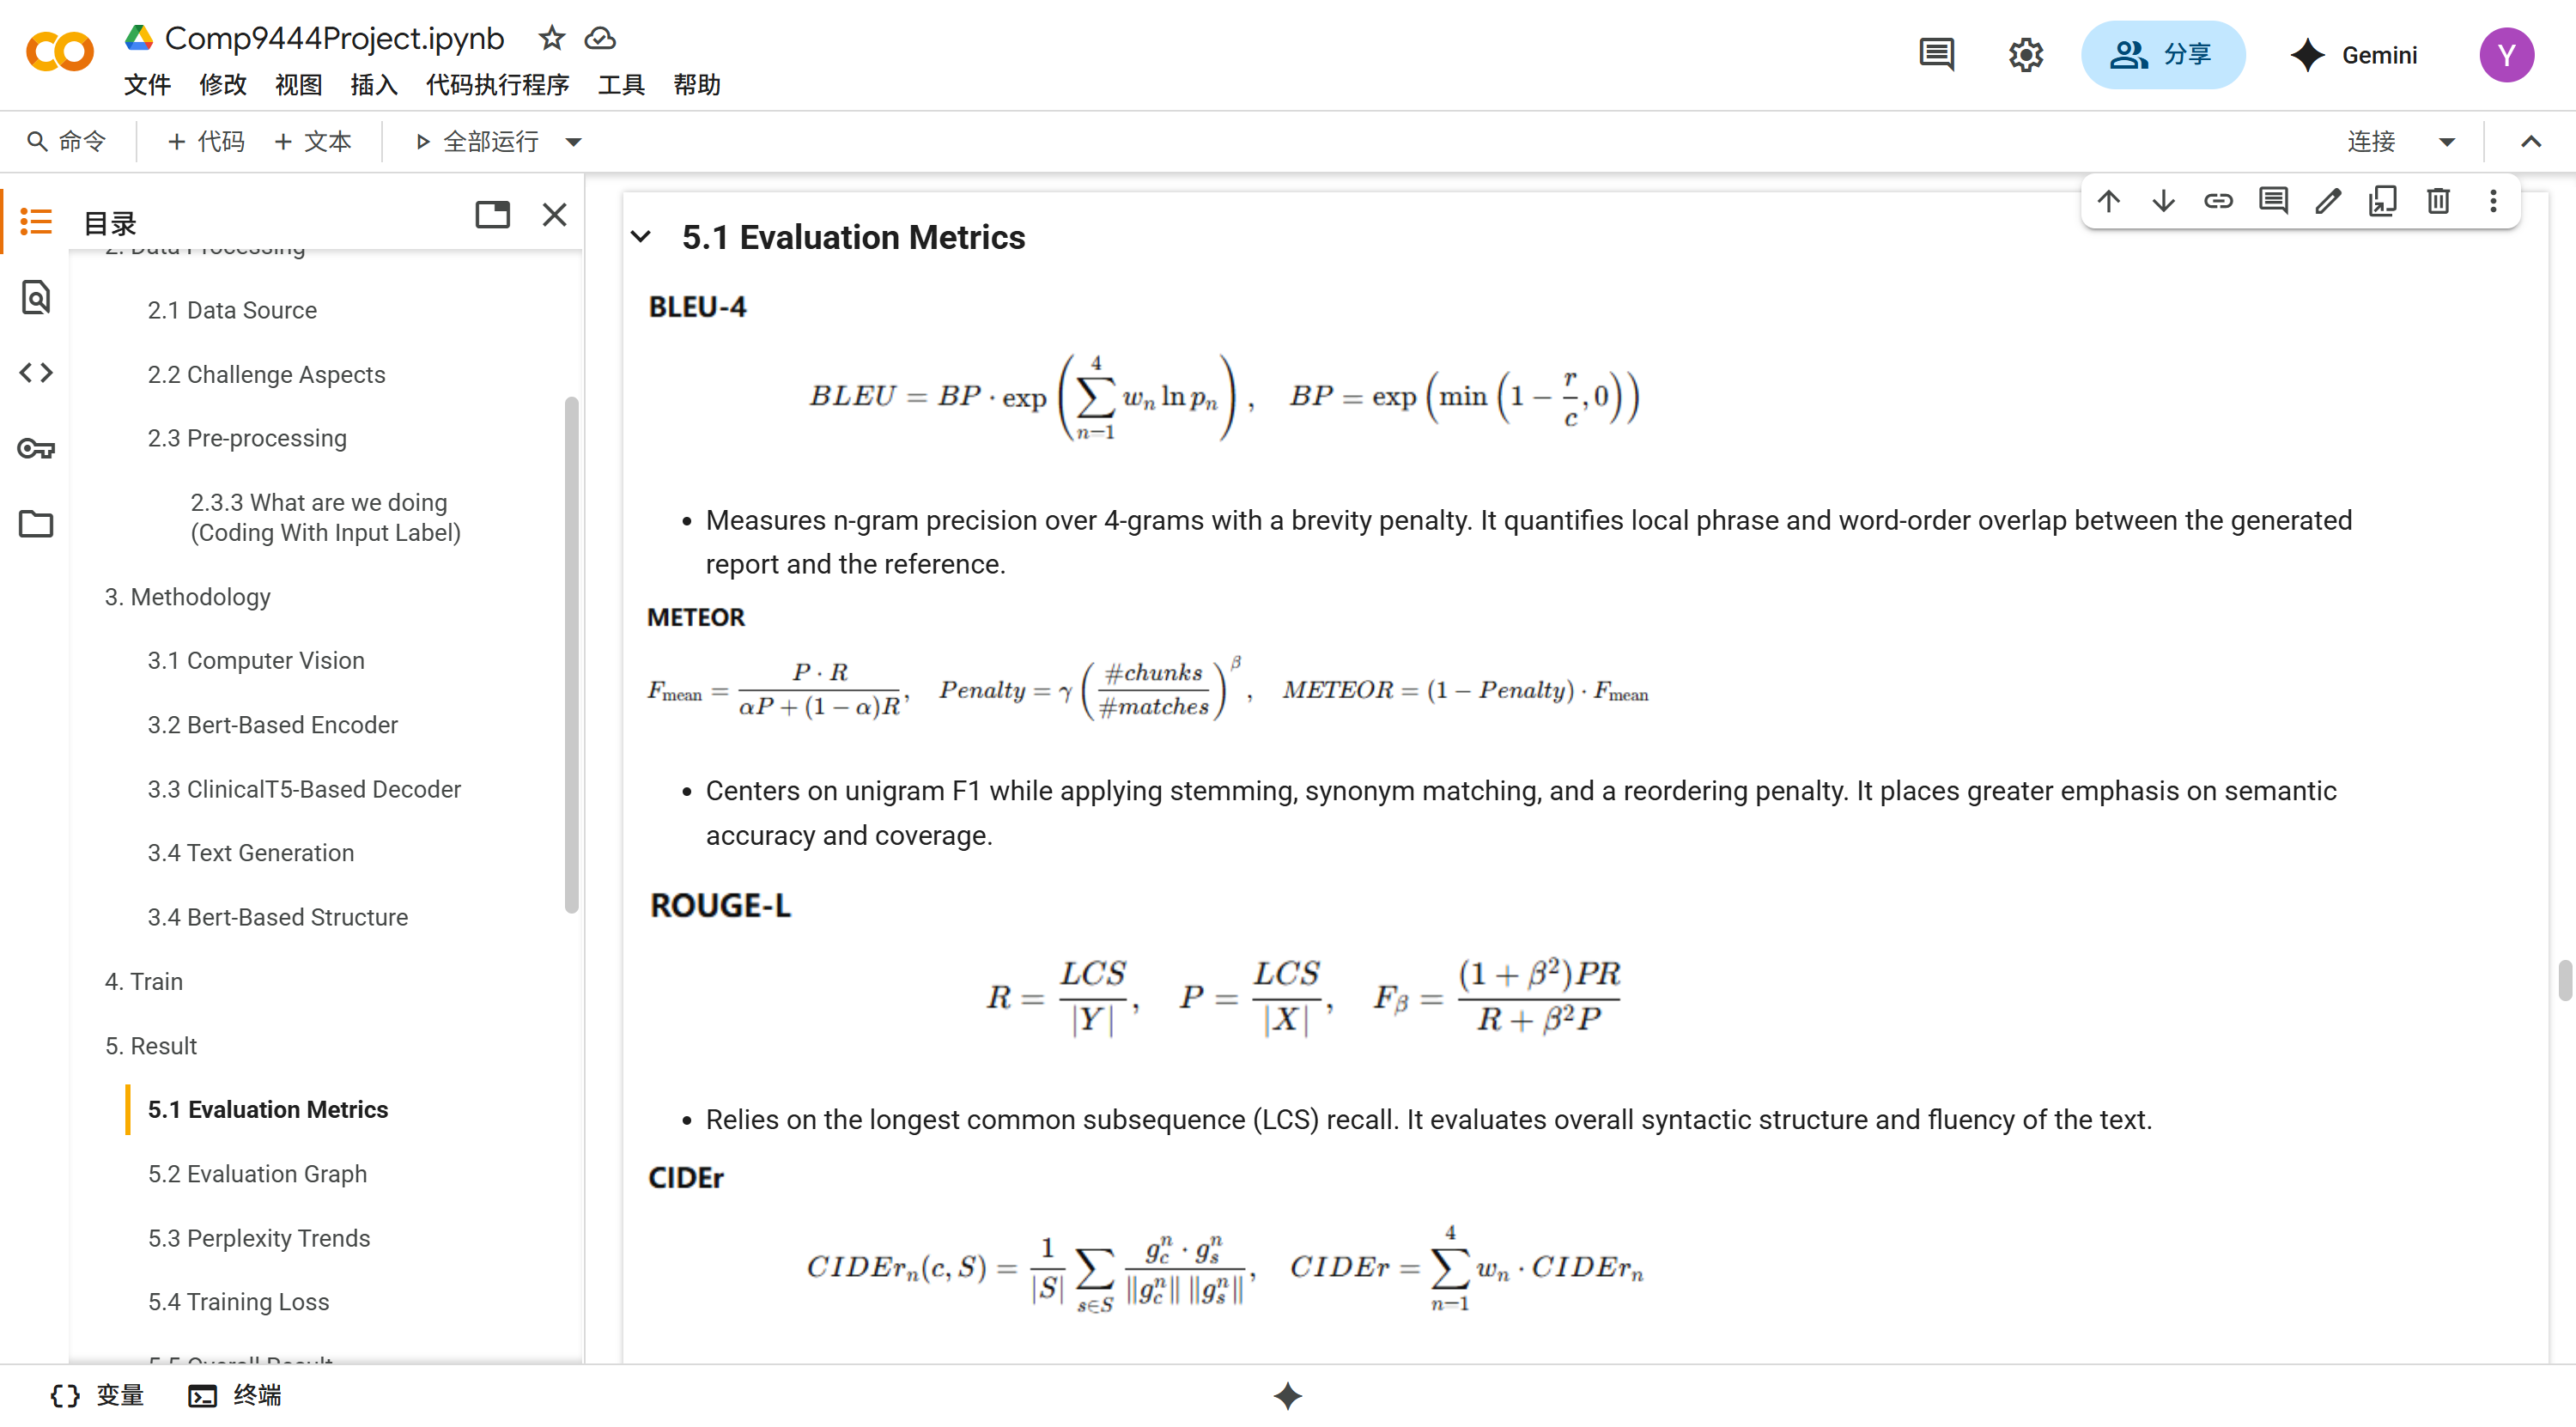
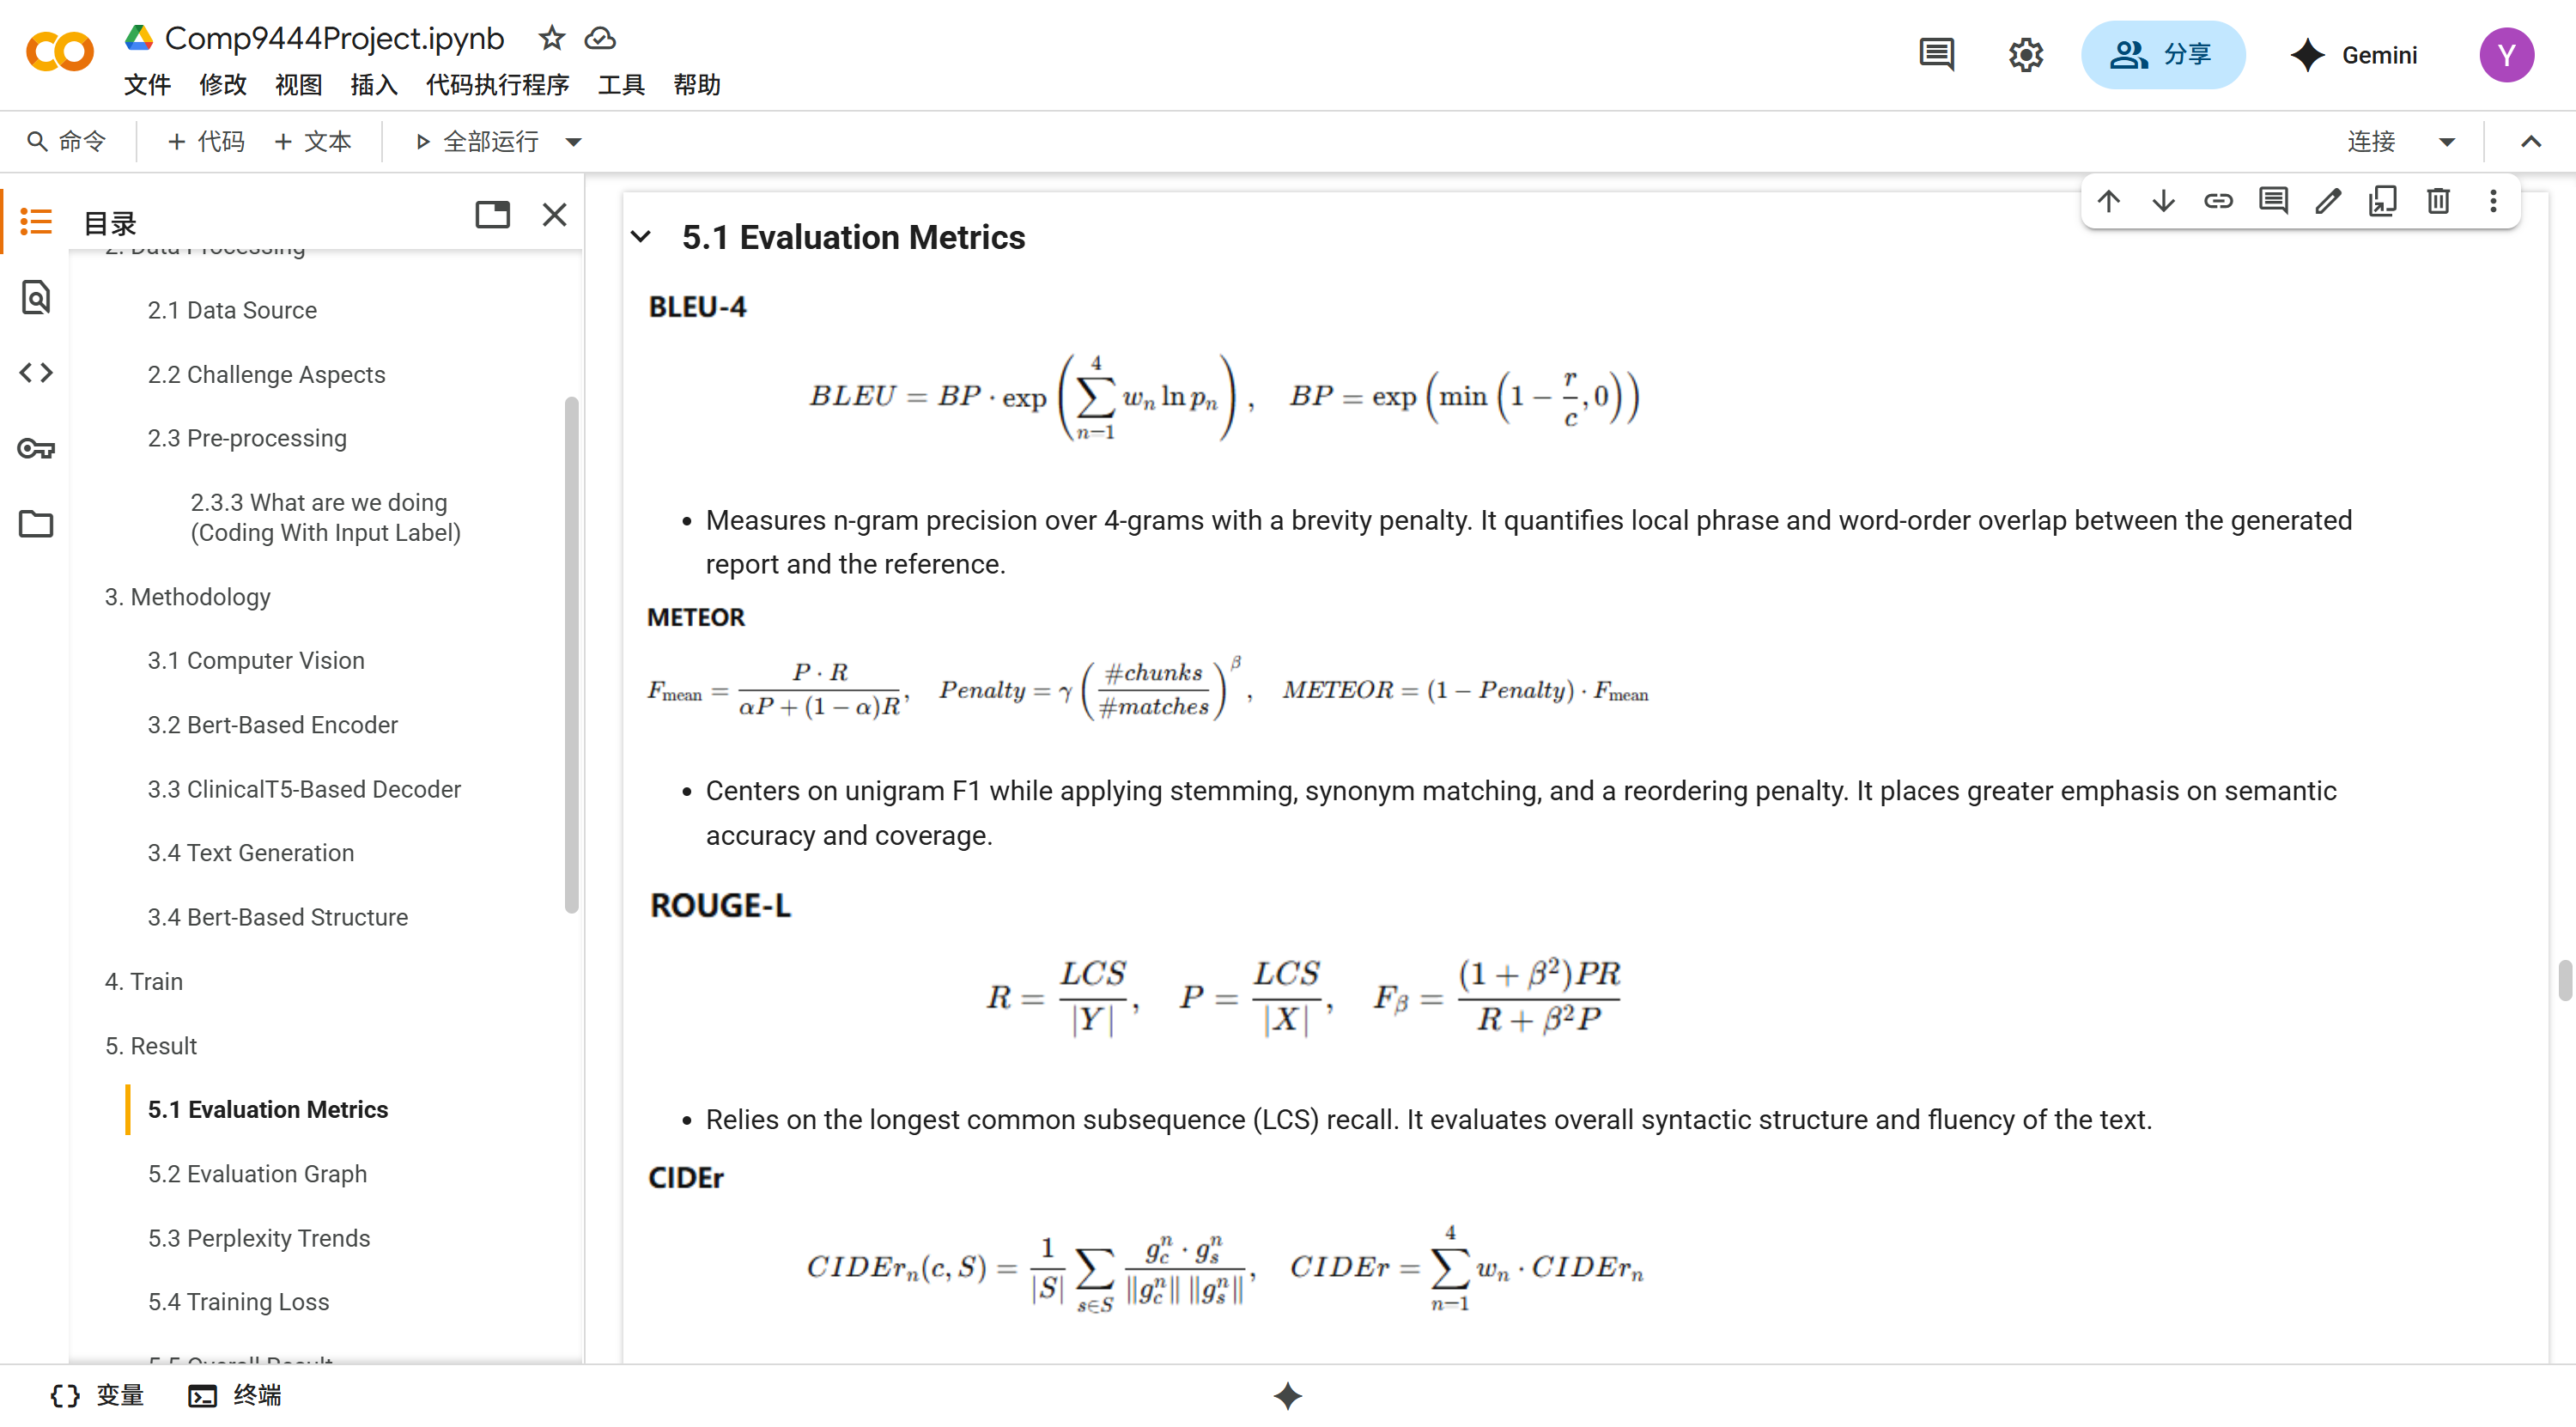

In [ ]:
init(autoreset=True)

# --- get data for evaluation ---
def get_dataloaders(
    configs, bert_tokenizer, t5_tokenizer, dataset_path, img_archive=None
):
    with_label = configs.get("train_with_label", False)
    if with_label:
        dataset = Img2txtDatasetWithLabel(
            configs=configs,
            bert_tokenizer=bert_tokenizer,
            t5_tokenizer=t5_tokenizer,
            data_set_path=dataset_path,
            img_archive=img_archive,
        )
    else:
        dataset = Img2txtDataset(
            configs=configs,
            bert_tokenizer=bert_tokenizer,
            t5_tokenizer=t5_tokenizer,
            data_set_path=dataset_path,
            img_archive=img_archive,
        )

    tqdm.write(Fore.BLUE + f">> ✅ From {dataset_path} load {len(dataset)} samples <<")

    dataloader = DataLoader(
        dataset,
        batch_size=configs["batch_size"],
        num_workers=configs["num_workers"],
        pin_memory=True,
        shuffle=True,
        drop_last=True,
        worker_init_fn=worker_init_fn,
    )

    return dataloader

class Scheduler:
    def get_params(self) -> Dict:
        return {"max_new_tokens": 150,
                "min_new_tokens": 86,
                "num_beams": 5,
                "do_sample": True,
                "temperature": 1.2,
                "top_p": 0.85,  # nucleus sampling
                "top_k": 30,  # top-k sampling
                "no_repeat_ngram_size": 4,
                "repetition_penalty": 1
                }
scheduler = Scheduler()
# --- End of Placeholders ---

class evaluator:
    def __init__(self, model, valid_data_loader, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.valid_loader = valid_data_loader

    def compute_rouge(self, cands: List[str], refs: List[List[str]]):
        """
        Compute ROUGE metrics (ROUGE-1, ROUGE-2, ROUGE-L)
        """
        scorer = rouge_scorer.RougeScorer(
            ["rouge1", "rouge2", "rougeL"], use_stemmer=True
        )
        aggregator = scoring.BootstrapAggregator()

        valid_pairs = 0

        for cand, ref_list in zip(cands, refs):
            # filter out empty strings
            valid_refs = [ref.strip() for ref in ref_list if ref.strip()]
            cand = cand.strip()

            if not cand or not valid_refs:
                continue

            try:
                # Get scores from all valid references
                scores = []
                for ref in valid_refs:
                    score = scorer.score(ref, cand)

                    # validate the structure of the returned score object
                    if hasattr(score["rouge1"], "fmeasure"):
                        scores.append(score)
                    else:
                        print(
                            f"Warning: Unexpected score object structure: {type(score['rouge1'])}"
                        )

                if not scores:
                    continue

                # Select the highest score for each metric
                best = {}
                for metric in ["rouge1", "rouge2", "rougeL"]:
                    try:
                        best_score_obj = max(scores, key=lambda s: s[metric].fmeasure)[
                            metric
                        ]
                        best[metric] = best_score_obj
                    except (AttributeError, KeyError, TypeError) as e:
                        print(f"Warning: Error processing {metric}: {e}")
                        best[metric] = scoring.Score(
                            precision=0.0, recall=0.0, fmeasure=0.0
                        )

                aggregator.add_scores(best)
                valid_pairs += 1

            except Exception as e:
                print(f"Warning: Error processing candidate text: {e}")
                continue

        if valid_pairs == 0:
            return {"rouge1_f": 0.0, "rouge2_f": 0.0, "rougeL_f": 0.0}

        try:
            result = aggregator.aggregate()

            return {
                "rouge1_f": result["rouge1"].mid.fmeasure,
                "rouge2_f": result["rouge2"].mid.fmeasure,
                "rougeL_f": result["rougeL"].mid.fmeasure,
            }
        except Exception as e:
            print(f"Warning: Error aggregating results: {e}")
            return {"rouge1_f": 0.0, "rouge2_f": 0.0, "rougeL_f": 0.0}

    def compute_cider(self, cands: List[str], refs: List[List[str]]) -> float:
        """
        Compute CIDEr metric

        Args:
            cands: List of candidate texts
            refs: List of reference text lists

        Returns:
            CIDEr score (average value)
        """
        # pycocoevalcap interface requires format: {idx: [cand]}, {idx: [ref1, ref2, ...]}
        hypo = {i: [c] for i, c in enumerate(cands)}
        ref_dict = {i: rs for i, rs in enumerate(refs)}
        cider_scorer = Cider()
        score, _ = cider_scorer.compute_score(ref_dict, hypo)
        return score

    def compute_token_metrics(
        self, pred_tokens: List[str], ref_tokens: List[str]
    ) -> Dict[str, float]:
        if not pred_tokens and not ref_tokens:
            return {
                "token_accuracy": 1.0,
                "token_precision": 1.0,
                "token_recall": 1.0,
                "token_f1": 1.0,
            }
        if not pred_tokens or not ref_tokens:
            return {
                "token_accuracy": 0.0,
                "token_precision": 0.0,
                "token_recall": 0.0,
                "token_f1": 0.0,
            }

        # --- Token Accuracy  ---
        correctly_predicted_count = sum(
            1 for p_token in pred_tokens if p_token in ref_tokens
        )
        accuracy = correctly_predicted_count / len(pred_tokens)

        # --- Precision, Recall, F1 ---
        pred_counter = Counter(pred_tokens)
        ref_counter = Counter(ref_tokens)

        intersection_count = sum((pred_counter & ref_counter).values())

        precision = intersection_count / len(pred_tokens)
        recall = intersection_count / len(ref_tokens)

        f1 = (
            (2 * precision * recall) / (precision + recall)
            if (precision + recall) > 0
            else 0.0
        )

        return {
            "token_accuracy": accuracy,
            "token_precision": precision,
            "token_recall": recall,
            "token_f1": f1,
        }


    @torch.no_grad()
    def evaluate(self) -> Dict[str, float]:
        assert (
            self.valid_loader is not None
        ), "Validation loader is not initialized. Please set evaluate=True when creating the trainer."

        bleu = evaluate.load("bleu")
        meteor = evaluate.load("meteor")

        total_nll = 0.0
        total_tokens = 0

        all_preds = []
        all_refs = []

        flat_pred_tokens = []
        flat_ref_tokens = []

        self.model.eval()
        tqdm.write(Fore.MAGENTA + " >> ⚡️ Evaluating model... ⚡️ << ")
        evaluate_bar = tqdm(
            self.valid_loader, desc="Evaluating", file=sys.stdout, position=1
        )

        for batch in evaluate_bar:

            batch_data = get_batch_input_data(batch, self.device, self.tokenizer)

            outputs, encoder_out = self.model(
                cls_tok=batch_data["cls_tok"],
                sep_tok=batch_data["sep_tok"],
                input_text=batch_data["input_ids"],
                segment=batch_data["segment_ids"],
                attn_mask=batch_data["attn_mask"],
                input_img=batch_data["img"],
                decoder_input_ids=batch_data["decoder_input_ids"],
                labels=batch_data["labels"],
                return_encoder_output=True,
            )

            mask = batch_data["labels"] != -100
            n_tokens = mask.sum().item()
            total_nll += outputs.loss.item() * n_tokens
            total_tokens += n_tokens

            encoder_hidden = self.model.decoder.init_state(encoder_out)

            decode_params = scheduler.get_params()

            decode_params.update(
                {
                    "pad_token_id": self.tokenizer.pad_token_id,
                    "eos_token_id": self.tokenizer.eos_token_id,
                }
            )

            generated_ids = self.model.decoder.generate(
                encoder_outputs=encoder_hidden["encoder_outputs"], **decode_params
            )
            preds = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)


            batch_size = batch_data["labels"].size(0)
            refs = []
            for i in range(batch_size):
                label_seq = batch_data["labels"][i].tolist()
                try:
                    idx = label_seq.index(-100)
                    label_seq = label_seq[:idx]
                except ValueError:
                    label_seq = [tok for tok in label_seq if tok >= 0]
                if not label_seq:
                    continue
                refs.append(self.tokenizer.decode(label_seq, skip_special_tokens=True))

            n = min(len(preds), len(refs))
            all_preds.extend(preds[:n])
            all_refs.extend([[r] for r in refs[:n]])

            for p, r in zip(preds[:n], refs[:n]):
                ptoks = self.tokenizer.tokenize(p)
                rtoks = self.tokenizer.tokenize(r)
                flat_pred_tokens.extend(ptoks)
                flat_ref_tokens.extend(rtoks)

            del batch_data, outputs, encoder_out, encoder_hidden, generated_ids
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # BLEU & METEOR
        bleu_result = bleu.compute(predictions=all_preds, references=all_refs, max_order=4)
        bleu4 = bleu_result["bleu"] if bleu_result else 0.0

        meteor_result = meteor.compute(predictions=all_preds, references=[r[0] for r in all_refs])
        meteor_score = meteor_result["meteor"] if meteor_result else 0.0

        try:
            rouge_scores = self.compute_rouge(all_preds, all_refs)
        except Exception as e:
            tqdm.write(f"Warning: ROUGE computation failed: {e}")
            rouge_scores = {"rouge1_f": 0.0, "rouge2_f": 0.0, "rougeL_f": 0.0}

        try:
            cider_score = self.compute_cider(all_preds, all_refs)
        except Exception as e:
            tqdm.write(f"Warning: CIDEr computation failed: {e}")
            cider_score = 0.0

        try:
            token_metrics = self.compute_token_metrics(
                flat_pred_tokens, flat_ref_tokens
            )
        except Exception as e:
            tqdm.write(f"Warning: Token metrics computation failed: {e}")
            token_metrics = {
                "token_accuracy": 0.0,
                "token_precision": 0.0,
                "token_recall": 0.0,
                "token_f1": 0.0,
            }
        metrics = {
            "BLEU-4": bleu4,
            "METEOR": meteor_score,
            # New ROUGE metrics
            "ROUGE-1": rouge_scores["rouge1_f"],
            "ROUGE-2": rouge_scores["rouge2_f"],
            "ROUGE-L": rouge_scores["rougeL_f"],
            # CIDEr metric
            "CIDEr": cider_score,

            "TOKEN_ACCURACY": token_metrics["token_accuracy"],
            "TOKEN_PRECISION": token_metrics["token_precision"],
            "TOKEN_RECALL": token_metrics["token_recall"],
            "TOKEN_F1": token_metrics["token_f1"],
        }

        return metrics


def evaluation(
    configs: Dict[str, Any],
    valid_dataset_path: str,
    valid_img_archive_path: Optional[str],
    model_weights_dir: str,
):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(Fore.CYAN + f"Using device: {device}")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        print(Fore.GREEN + "Initial GPU memory cleanup completed")

    pt_dir = model_weights_dir
    pt_files = [os.path.join(pt_dir, f) for f in os.listdir(pt_dir) if f.endswith(".pt")]

    print(Fore.CYAN + f"Found {len(pt_files)} checkpoint files:")
    for f in pt_files:
        print(f"  - {f}")

    all_fold_results = []

    bert_tokenizer = AutoTokenizer.from_pretrained(
        "bert-base-uncased", do_lower_case=True
    )
    t5_tokenizer = AutoTokenizer.from_pretrained("t5-base")

    for idx, model_path in enumerate(pt_files):
        print(Fore.MAGENTA + f"\n============================== EVALUATING {idx+1}/{len(pt_files)} ==============================")
        print(f"Loading checkpoint: {model_path}")

        checkpoint_name = os.path.basename(model_path).lower()
        configs = configs.copy()

        if "label" in checkpoint_name:
            configs["train_with_label"] = True
            print(Fore.YELLOW + "Detected label-based training, setting train_with_label=True")
        else:
            configs["train_with_label"] = False
            print(Fore.YELLOW + "No label detected, setting train_with_label=False")

        if "vit" in checkpoint_name:
            configs["img_encoder"] = "ViT"
            print(Fore.YELLOW + "Detected ViT in checkpoint name, setting img_encoder=ViT")
        elif "densenet" in checkpoint_name:
            configs["img_encoder"] = "chexnet121"
            print(Fore.YELLOW + "Detected ChexNet in checkpoint name, setting img_encoder=chexnet121")
        elif "resnet" in checkpoint_name:
            configs["img_encoder"] = "resnet101_101-elastic"
            print(Fore.YELLOW + "Detected ResNet in checkpoint name, setting img_encoder=resnet101_101-elastic")
        else:
            raise NotFoundErr("Could not determine img_encoder from checkpoint name. Please ensure the naming convention is correct.")

        val_loader = get_dataloaders(
            configs=configs,
            bert_tokenizer=bert_tokenizer,
            t5_tokenizer=t5_tokenizer,
            dataset_path=valid_dataset_path,
            img_archive=valid_img_archive_path
        )


        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

        model = MedViLLT5ForReportGeneration(
            encoder_model_path=ENCODER_BASE_PATH,
            decoder_model_path=DECODER_BASE_PATH,
            configs=configs,
        )

        try:
            ckpt = torch.load(model_path, map_location=device)
            model.load_state_dict(ckpt["model_state_dict"])
            model.to(device)
            model.eval()
        except Exception as e:
            print(Fore.RED + f"Failed to load model state_dict. Error: {e}")
            exit(1)

        model_evaluator = evaluator(model, val_loader, t5_tokenizer, device)
        results = model_evaluator.evaluate()

        results['checkpoint_name'] = os.path.basename(model_path)
        results['checkpoint_index'] = idx + 1
        all_fold_results.append(results)

        print(Fore.YELLOW + f"Results for checkpoint {idx + 1} ({os.path.basename(model_path)}):")
        for key, value in results.items():
            if key not in ['checkpoint_name', 'checkpoint_index']:
                print(f"  {key}: {value:.4f}")


        if torch.cuda.is_available():
            del model
            del model_evaluator
            del val_loader
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
            print(Fore.GREEN + f"GPU memory and objects cleared after evaluation {idx + 1}")

    if all_fold_results:
        summary_results = compute_summary_statistics(all_fold_results)
        save_evaluation_results(all_fold_results, summary_results, model_weights_dir)

        print(Fore.GREEN + "\n" + "="*80)
        print(Fore.GREEN + "EVALUATION SUMMARY STATISTICS")
        print(Fore.GREEN + "="*80)
        for metric, stats in summary_results.items():
            print(f"{metric}:")
            print(f"  Mean: {stats['mean']:.4f} ± {stats['std']:.4f}")
            print(f"  Min: {stats['min']:.4f} | Max: {stats['max']:.4f}")

        print(Fore.CYAN + f"\nResults saved to evaluation_results/ directory")
    else:
        print(Fore.RED + "No results to save!")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        print(Fore.GREEN + "Final GPU memory cleanup completed")


def compute_summary_statistics(all_results):

    if not all_results:
        return {}

    metric_names = set()
    for result in all_results:
        metric_names.update(result.keys())

    exclude_keys = {'checkpoint_name', 'checkpoint_index'}
    metric_names = metric_names - exclude_keys

    summary = {}
    for metric in metric_names:
        values = []
        for result in all_results:
            if metric in result and isinstance(result[metric], (int, float)):
                values.append(result[metric])

        if values:
            summary[metric] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'min': np.min(values),
                'max': np.max(values),
                'count': len(values)
            }

    return summary


def save_evaluation_results(all_results, summary_results, base_dir):

    save_dir = os.path.join(os.path.dirname(base_dir), "evaluation_results")
    os.makedirs(save_dir, exist_ok=True)

    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    detailed_file = os.path.join(save_dir, f"evaluation_detailed_results_{timestamp}.json")
    with open(detailed_file, 'w', encoding='utf-8') as f:
        json.dump({
            'evaluation_info': {
                'timestamp': timestamp,
                'total_checkpoints': len(all_results),
                'base_model_dir': base_dir
            },
            'detailed_results': all_results
        }, f, indent=2, ensure_ascii=False)

    summary_file = os.path.join(save_dir, f"evaluation_summary_results_{timestamp}.json")
    with open(summary_file, 'w', encoding='utf-8') as f:
        json.dump({
            'evaluation_info': {
                'timestamp': timestamp,
                'total_checkpoints': len(all_results),
                'base_model_dir': base_dir
            },
            'summary_statistics': summary_results
        }, f, indent=2, ensure_ascii=False)

    csv_file = os.path.join(save_dir, f"evaluation_results_{timestamp}.csv")
    save_results_to_csv(all_results, csv_file)

    print(Fore.CYAN + f"Detailed results saved to: {detailed_file}")
    print(Fore.CYAN + f"Summary results saved to: {summary_file}")
    print(Fore.CYAN + f"CSV results saved to: {csv_file}")


def save_results_to_csv(all_results, csv_file):
    import pandas as pd

    if not all_results:
        return

    df = pd.DataFrame(all_results)

    cols = ['checkpoint_index', 'checkpoint_name']
    metric_cols = [col for col in df.columns if col not in cols]
    df = df[cols + sorted(metric_cols)]

    df.to_csv(csv_file, index=False, encoding='utf-8-sig')

if __name__ == '__main__':
    ENCODER_BASE_PATH = "models/pre_model_weights/MedViLL"
    DECODER_BASE_PATH = "models/pre_model_weights/ClinicalT5"
    MODEL_WEIGHTS_DIR = "checkpoints/RadScribe_Train"
    CONFIG_FILE_PATH = "configs/evaluation.yaml"
    DATASET_PATH = "data/mimic/Test.jsonl"
    IMG_ARCHIVE_PATH = "data/preprocessed/mimic/Test.tar.gz"

    os.chdir(os.path.dirname(os.path.abspath(__file__)))
    print(f"Current working directory: {os.getcwd()}")

    with open(CONFIG_FILE_PATH, "r") as f:
        configs = yaml.safe_load(f)


    os.makedirs(MODEL_WEIGHTS_DIR, exist_ok=True)


    evaluation(configs=configs,
               valid_dataset_path=DATASET_PATH,
               valid_img_archive_path=IMG_ARCHIVE_PATH,
               model_weights_dir=MODEL_WEIGHTS_DIR)

    print(Fore.GREEN + "\n✅ Evaluation completed! Results have been saved to evaluation_results/ directory.")

In [ ]:
class evaluator:
    def __init__(self, model, valid_data_loader, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.valid_loader = valid_data_loader

        # self.clinical_terms = set()

        self.linker = SciSpacyLinker()

    def compute_rouge(self, cands: List[str], refs: List[List[str]]):
        """
        Compute ROUGE metrics (ROUGE-1, ROUGE-2, ROUGE-L)
        """
        scorer = rouge_scorer.RougeScorer(
            ["rouge1", "rouge2", "rougeL"], use_stemmer=True
        )
        aggregator = scoring.BootstrapAggregator()

        valid_pairs = 0

        for cand, ref_list in zip(cands, refs):
            # filter out empty strings
            valid_refs = [ref.strip() for ref in ref_list if ref.strip()]
            cand = cand.strip()

            if not cand or not valid_refs:
                continue

            try:
                # Get scores from all valid references
                scores = []
                for ref in valid_refs:
                    score = scorer.score(ref, cand)

                    # validate the structure of the returned score object
                    if hasattr(score["rouge1"], "fmeasure"):
                        scores.append(score)
                    else:
                        print(
                            f"Warning: Unexpected score object structure: {type(score['rouge1'])}"
                        )

                if not scores:
                    continue

                # Select the highest score for each metric
                best = {}
                for metric in ["rouge1", "rouge2", "rougeL"]:
                    try:
                        best_score_obj = max(scores, key=lambda s: s[metric].fmeasure)[
                            metric
                        ]
                        best[metric] = best_score_obj
                    except (AttributeError, KeyError, TypeError) as e:
                        print(f"Warning: Error processing {metric}: {e}")
                        best[metric] = scoring.Score(
                            precision=0.0, recall=0.0, fmeasure=0.0
                        )

                aggregator.add_scores(best)
                valid_pairs += 1

            except Exception as e:
                print(f"Warning: Error processing candidate text: {e}")
                continue

        if valid_pairs == 0:
            return {"rouge1_f": 0.0, "rouge2_f": 0.0, "rougeL_f": 0.0}

        try:
            result = aggregator.aggregate()

            return {
                "rouge1_f": result["rouge1"].mid.fmeasure,
                "rouge2_f": result["rouge2"].mid.fmeasure,
                "rougeL_f": result["rougeL"].mid.fmeasure,
            }
        except Exception as e:
            print(f"Warning: Error aggregating results: {e}")
            return {"rouge1_f": 0.0, "rouge2_f": 0.0, "rougeL_f": 0.0}

    def compute_cider(self, cands: List[str], refs: List[List[str]]) -> float:
        """
        Compute CIDEr metric

        Args:
            cands: List of candidate texts
            refs: List of reference text lists

        Returns:
            CIDEr score (average value)
        """
        # pycocoevalcap interface requires format: {idx: [cand]}, {idx: [ref1, ref2, ...]}
        hypo = {i: [c] for i, c in enumerate(cands)}
        ref_dict = {i: rs for i, rs in enumerate(refs)}
        cider_scorer = Cider()
        score, _ = cider_scorer.compute_score(ref_dict, hypo)
        return score  # CIDEr score (average value)

    def compute_clinical_f1(
        self, cands: List[str], refs: List[List[str]]
    ) -> Dict[str, float]:
        """
        Compute Clinical F1 metric based on clinical terms
        For each candidate and its corresponding references (take union of multiple refs):
        - Extract clinical terms from predicted and reference texts
        - Compute overall Precision, Recall, F1, and Accuracy across all samples

        Args:
            cands: List of candidate texts
            refs: List of reference text lists

        Returns:
            Dictionary containing clinical precision, recall, F1, and accuracy scores
        """

        def get_unique_word(text_set: set):
            return {
                token
                for term in text_set
                for token in re.findall(r"[A-Za-z0-9]+", term)
            }

        def length_penalty(pred_len, ref_len, sigma=5.0, alpha=2.0, rate=1):
            assert 0 < rate <= 1
            d = abs(pred_len - ref_len)
            return np.exp(alpha * np.exp(-(d**2) / (2 * sigma**2))) ** rate

        y_true = []
        y_pred = []

        penalties = []

        for cand, ref_list in zip(cands, refs):

            pred_terms = set(self.linker.extract_umls_cuis(cand))

            ref_terms = set()
            for ref in ref_list:
                ref_terms.update(self.linker.extract_umls_cuis(ref))

            pred_terms = get_unique_word(pred_terms)
            ref_terms = get_unique_word(ref_terms)

            pen = length_penalty(len(pred_terms), len(ref_terms))
            penalties.append(pen)

            for cui in ref_terms.union(pred_terms):
                y_true.append(1 if cui in ref_terms else 0)
                y_pred.append(1 if cui in pred_terms else 0)

        if len(y_true) == 0 or sum(y_true) == 0:
            return {
                "clinical_precision": 0.0,
                "clinical_recall": 0.0,
                "clinical_f1": 0.0,
                "clinical_accuracy": 0.0,
            }

        p, r, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="binary", zero_division=0
        )

        correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
        accuracy = correct / len(y_true)

        avg_penalty = float(np.mean(penalties))

        p, r, f1, accuracy = map(
            lambda x: np.tanh(avg_penalty * x), [p, r, f1, accuracy]
        )

        return {
            "clinical_precision": p,
            "clinical_recall": r,
            "clinical_f1": f1,
            "clinical_accuracy": accuracy,
        }

    def compute_token_metrics(
        self, pred_tokens: List[str], ref_tokens: List[str]
    ) -> Dict[str, float]:
        """
        Computes token-based metrics based on presence in the reference list, not on exact position.
        - Accuracy: What proportion of predicted tokens are valid (i.e., exist in ref_tokens)?
        - Precision/Recall/F1: Based on the overlap of unique tokens between predicted and reference sets.
        """
        if not pred_tokens and not ref_tokens:
            return {
                "token_accuracy": 1.0,
                "token_precision": 1.0,
                "token_recall": 1.0,
                "token_f1": 1.0,
            }
        if not pred_tokens or not ref_tokens:
            return {
                "token_accuracy": 0.0,
                "token_precision": 0.0,
                "token_recall": 0.0,
                "token_f1": 0.0,
            }

        # --- "Token Accuracy" ---
        correctly_predicted_count = sum(
            1 for p_token in pred_tokens if p_token in ref_tokens
        )
        accuracy = correctly_predicted_count / len(pred_tokens)

        # --- Precision, Recall, F1 ---
        pred_set = set(pred_tokens)
        ref_set = set(ref_tokens)

        intersection = pred_set.intersection(ref_set)

        precision = len(intersection) / len(pred_set)

        recall = len(intersection) / len(ref_set)

        f1 = (
            (2 * precision * recall) / (precision + recall)
            if (precision + recall) > 0
            else 0.0
        )

        return {
            "token_accuracy": accuracy,
            "token_precision": precision,
            "token_recall": recall,
            "token_f1": f1,
        }

    @torch.no_grad()
    def evaluate(self, epoch: int = 0) -> Dict[str, float]:
        assert (
            self.valid_loader is not None
        ), "Validation loader is not initialized. Please set evaluate=True when creating the trainer."

        bleu = evaluate.load("bleu")
        meteor = evaluate.load("meteor")

        total_nll = 0.0
        total_tokens = 0

        all_preds = []
        all_refs = []

        flat_pred_tokens = []
        flat_ref_tokens = []

        self.model.eval()
        tqdm.write(Fore.MAGENTA + " >> ⚡️ Evaluating model... ⚡️ << ")
        evaluate_bar = tqdm(
            self.valid_loader, desc="Evaluating", file=sys.stdout, position=1
        )

        for batch in evaluate_bar:

            batch_data = get_batch_input_data(batch, self.device, self.tokenizer)

            outputs, encoder_out = self.model(
                cls_tok=batch_data["cls_tok"],
                sep_tok=batch_data["sep_tok"],
                input_text=batch_data["input_ids"],
                segment=batch_data["segment_ids"],
                attn_mask=batch_data["attn_mask"],
                input_img=batch_data["img"],
                decoder_input_ids=batch_data["decoder_input_ids"],
                labels=batch_data["labels"],
                return_encoder_output=True,
            )

            mask = batch_data["labels"] != -100
            n_tokens = mask.sum().item()
            total_nll += outputs.loss.item() * n_tokens
            total_tokens += n_tokens

            encoder_hidden = self.model.decoder.init_state(encoder_out)

            decode_params = scheduler.get_params(epoch)

            decode_params.update(
                {
                    "pad_token_id": self.tokenizer.pad_token_id,
                    "eos_token_id": self.tokenizer.eos_token_id,
                }
            )

            generated_ids = self.model.decoder.generate(
                encoder_outputs=encoder_hidden["encoder_outputs"], **decode_params
            )
            preds = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            batch_size = batch_data["labels"].size(0)
            refs = []
            for i in range(batch_size):
                label_seq = batch_data["labels"][i].tolist()

                try:
                    idx = label_seq.index(-100)
                    label_seq = label_seq[:idx]
                except ValueError:
                    label_seq = [tok for tok in label_seq if tok >= 0]
                if not label_seq:
                    continue
                refs.append(self.tokenizer.decode(label_seq, skip_special_tokens=True))

            n = min(len(preds), len(refs))
            all_preds.extend(preds[:n])
            all_refs.extend([[r] for r in refs[:n]])

            for p, r in zip(preds[:n], refs[:n]):
                ptoks = self.tokenizer.tokenize(p)
                rtoks = self.tokenizer.tokenize(r)
                flat_pred_tokens.extend(ptoks)
                flat_ref_tokens.extend(rtoks)

        # BLEU & METEOR
        bleu4 = bleu.compute(predictions=all_preds, references=all_refs, max_order=4)[
            "bleu"
        ]
        meteor_score = meteor.compute(
            predictions=all_preds, references=[r[0] for r in all_refs]
        )["meteor"]

        # Compute new evaluation metrics with error handling
        try:
            rouge_scores = self.compute_rouge(all_preds, all_refs)
        except Exception as e:
            tqdm.write(f"Warning: ROUGE computation failed: {e}")
            rouge_scores = {"rouge1_f": 0.0, "rouge2_f": 0.0, "rougeL_f": 0.0}

        try:
            cider_score = self.compute_cider(all_preds, all_refs)
        except Exception as e:
            tqdm.write(f"Warning: CIDEr computation failed: {e}")
            cider_score = 0.0

        try:
            clinical_f1_scores = self.compute_clinical_f1(all_preds, all_refs)
        except Exception as e:
            tqdm.write(f"Warning: Clinical F1 computation failed: {e}")
            clinical_f1_scores = {
                "clinical_precision": 0.0,
                "clinical_recall": 0.0,
                "clinical_f1": 0.0,
                "clinical_accuracy": 0.0,
            }

        try:
            token_metrics = self.compute_token_metrics(
                flat_pred_tokens, flat_ref_tokens
            )
        except Exception as e:
            tqdm.write(f"Warning: Token metrics computation failed: {e}")
            token_metrics = {
                "token_accuracy": 0.0,
                "token_precision": 0.0,
                "token_recall": 0.0,
                "token_f1": 0.0,
            }

        self.model.train()

        # Combine all metrics
        metrics = {
            "BLEU-4": bleu4,
            "METEOR": meteor_score,
            # New ROUGE metrics
            "ROUGE-1": rouge_scores["rouge1_f"],
            "ROUGE-2": rouge_scores["rouge2_f"],
            "ROUGE-L": rouge_scores["rougeL_f"],
            # CIDEr metric
            "CIDEr": cider_score,
            # Clinical F1 metrics
            "CLINICAL_PRECISION": clinical_f1_scores["clinical_precision"],
            "CLINICAL_RECALL": clinical_f1_scores["clinical_recall"],
            "CLINICAL_F1": clinical_f1_scores["clinical_f1"],
            "CLINICAL_ACCURACY": clinical_f1_scores["clinical_accuracy"],
            "TOKEN_ACCURACY": token_metrics["token_accuracy"],
            "TOKEN_PRECISION": token_metrics["token_precision"],
            "TOKEN_RECALL": token_metrics["token_recall"],
            "TOKEN_F1": token_metrics["token_f1"],
        }

        return metrics


class SciSpacyLinker:

    def __init__(
        self,
        model: str = "en_core_sci_scibert",
        resolve_abbreviations: bool = True,
        linker_name: str = "umls",
    ):

        spacy.require_gpu()
        self.nlp = spacy.load(model)
        self.linker = self.nlp.add_pipe(
            "scispacy_linker",
            config={
                "resolve_abbreviations": resolve_abbreviations,
                "linker_name": linker_name,
            },
        )
        self.kb = self.linker.kb

    def extract_umls_cuis(
        self, text: str, score_threshold: float = None, top_k: int = None
    ) -> List[str]:
        doc = self.nlp(text)
        all_cuis: List[str] = []

        for ent in doc.ents:
            # ent._.kb_ents is List[Tuple[cui, score]]
            candidates: List[Tuple[str, float]] = ent._.kb_ents

            if score_threshold is not None:
                candidates = [
                    (cui, score)
                    for cui, score in candidates
                    if score >= score_threshold
                ]

            if top_k is not None:
                candidates = candidates[:top_k]

            for cui, _ in candidates:
                all_cuis.append(cui)

        return all_cuis

    def count_medical_terms_in_text(self, text: str) -> Counter:
        """
        Count UMLS CUIs in a given text.
        :param text: Input text to process.
        :return: Counter with CUIs and their counts.
        """
        counter = Counter()
        counter.update(self.extract_umls_cuis(text))
        return counter

    def count_medical_terms(self, file_paths: List[str]) -> Counter:
        counter = Counter()

        for fp in file_paths:
            with open(fp, "r", encoding="utf-8") as f:
                total = sum(1 for _ in f)
            with open(fp, "r", encoding="utf-8") as f:
                for line in tqdm(
                    f, desc=f"Processing {fp}", total=total, unit="line", leave=False
                ):
                    try:
                        obj = json.loads(line)
                    except json.JSONDecodeError:
                        continue
                    text = obj.get("text", "")
                    if text:
                        counter.update(self.extract_umls_cuis(text))
        return counter

    def filter_and_export(
        self, source: List[str] | str, output_file: str = ""
    ) -> Set[str]:
        source_type = type(source)

        if source_type == list:
            cui_counts = self.count_medical_terms(source)
        else:
            assert source_type == str and output_file == ""
            cui_counts = self.count_medical_terms_in_text(source)

        terms = set()

        for cui in cui_counts:
            ent = self.kb.cui_to_entity.get(cui)
            # if ent and set(ent.types) & self.allowed_types:
            if ent and set(ent.types):
                terms.add(ent.canonical_name.lower())

        if source_type == list:
            with open(output_file, "w", encoding="utf-8") as fout:
                json.dump({"terms": list(terms)}, fout, ensure_ascii=False, indent=2)

            tqdm.write(f"Wrote {len(terms)} terms to {output_file}")
            return terms

        return terms


if __name__ == "__main__":
    pass


### **5.2 Evaluation Graph**
This section compares the training performance of five model variants—ViT-RadScribe, ResNet-RadScribe, ResNet-label-RadScribe, DenseNet-RadScribe, and ViT-label-RadScribe—across different evaluation metrics.

<table>
<tr>
<td><img src="imgs/Chart_bleu4.png" alt="Fig.1"></td>
<td><img src="imgs/Chart_meteor.png" alt="Fig.2"></td>
</tr>
</table>

<table>
<tr>
<td><img src="imgs/Chart_rougel.png" alt="Fig.3"></td>
<td><img src="imgs/Chart_cider.png" alt="Fig.4"></td>
</tr>
</table>


For text-level metrics (BLEU-4, METEOR, ROUGE-L, CIDEr), ViT-label-RadScribe consistently leads across all four metrics, peaking around 80k steps, followed by ViT-RadScribe. DenseNet and ResNet variants perform relatively weaker, with limited improvements over the training process.

<br>
<br>

<table>
<tr>
<td><img src="imgs/Chart_accuracy.png" alt="Fig.5"></td>
<td><img src="imgs/Chart_precision.png" alt="Fig.6"></td>
</tr>
</table>

<table>
<tr>
<td><img src="imgs/Chart_recall.png" alt="Fig.7"></td>
<td><img src="imgs/Chart_f1.png" alt="Fig.8"></td>
</tr>
</table>


For token-level metrics (Accuracy, Precision, Recall, F1), all models achieve near-perfect token accuracy, but differences appear in precision and recall. DenseNet-label-RadScribe has a slight edge in precision, whereas ViT-label-RadScribe demonstrates the most balanced and steadily improving recall and F1 scores, indicating stronger coverage of medical entities while maintaining prediction accuracy.

<br>

Conclusion: ViT-label-RadScribe delivers the best overall performance across most metrics, particularly excelling at balancing text generation quality (high BLEU, ROUGE, METEOR, CIDEr) with entity-level coverage (high Recall, F1).

---
### **5.3 Perplexity Trends**

<img src="imgs/Perplexity_Trends.png" alt="Fig.1">


The top figure compares the perplexity across all model variants, with ViT-label-RadScribe achieving the lowest perplexity (2.6281), indicating more confident and consistent text generation.

### **5.4 Training Loss**

**1.Overall Convergence Trend**

All models show a rapid drop in loss during the initial training phase (first 2k–5k steps), indicating that they quickly learn effective feature representations in the early iterations. In the later phase (>20k steps), the loss reduction slows down and begins to plateau, suggesting that the models are approaching their optimal solutions. Fine-tuned models (prefixed with ft-) converge noticeably faster in the early stage, benefiting from pre-trained weights.

---
**2.Model-by-Model Comparison**

Models trained without label information have higher loss than their labeled counterparts, showing that label supervision effectively improves optimization and generation quality.


<table>
<tr>
<td><img src="imgs/3.png" alt="Fig.3"></td>
<td><img src="imgs/4.png" alt="Fig.4"></td>
</tr>
</table>

<table>
<tr>
<td><img src="imgs/9.png" alt="Fig.5"></td>
<td><img src="imgs/7.png" alt="Fig.6"></td>
</tr>
</table>

<table>
<tr>
<td><img src="imgs/2.png" alt="Fig.1"></td>
<td><img src="imgs/loss.png" alt="Fig.2"></td>
</tr>
</table>

We can roughly learn from those figure that all of our models are almost convergence within 30 epochs. Fine-tuned models generally have smaller fluctuations in the later stage, indicating more stable optimization. Models trained from scratch show greater fluctuation between 10k–40k steps, likely due to gradient oscillations when learning high-level features. Therefore, the final comparison is reliable.


---
### **5.5 Overall Result**

<img src="imgs/result.jpg" alt="Fig.3" style="width:100%; height:auto;">

We evaluate our models using standard metrics for text generation and clinical alignment, including BLEU-4, METEOR, ROUGE-L, CIDEr, Precision, Recall, F1-score, and Accuracy.

Among all evaluated models, ViT-label-RadScribe achieves the best overall performance:

- BLEU-4: 0.0956

- METEOR: 0.2807

- ROUGE-L: 0.2311

- CIDEr: 0.1093

- F1-score: 0.8236

- Precision: 0.8614

- Recall: 0.7889

- Accuracy: 0.99985

ViT-based models consistently outperform CNN-based models (e.g., ResNet, DenseNet), highlighting the advantages of the self-attention mechanism in capturing global dependencies in radiological images.

Furthermore, models with label supervision ("-label") significantly outperform their non-label counterparts. For instance, ViT-label-RadScribe outperforms ViT-RadScribe in BLEU-4 (0.0956 vs. 0.0882) and F1-score (0.8236 vs. 0.7739), demonstrating the effectiveness of explicitly incorporating disease labels during training.

Finally, compared to the baseline MedViLL, all proposed models show substantial improvements, all the metrics of the ViT-Label-RadScribe are perform much better then the MedViLL. Therefore, we can conclude that the main object of the model have been achieved.

### **5.6 How dose the Attention Mechanism work in ViT-label-RadScribe?**

**The attention when the models notice the lesion**

<table>
<tr>
<td><img src="imgs/attention_lung_pure_relative_change.jpg" alt="Fig.1" width="400"></td>
<td><img src="imgs/attention_opacification_pure_relative_change.jpg" alt="Fig.2" width="400"></td>
</tr>
</table>
<p style="text-align:center;">
  Fig.&nbsp;1&nbsp;–&nbsp;Haven’t notice the lesion
  &nbsp;&nbsp;|&nbsp;&nbsp;
  Fig.&nbsp;2&nbsp;–&nbsp;Notice the Opacification
</p>

<table>
<tr>
<td><img src="imgs/attention_pneumothorax_pure_relative_change.jpg" alt="Fig.2" width="400"></td>
<td><img src="imgs/attention_pleural_effusion_pure_relative_change.jpg" alt="Fig.2" width="400"></td>
</tr>
</table>
<p style="text-align:center;">
  Fig.&nbsp;3&nbsp;–&nbsp;Notice the Pneumothorax
  &nbsp;&nbsp;|&nbsp;&nbsp;
  Fig.&nbsp;4&nbsp;–&nbsp;Notice the pleural effusion
</p>


As demonstrated in Fig1, 2, 3,and 4, it is evident that there is a discernible discrepancy in the model's response to different lesions. Figure 1 illustrates the model's reaction when it is not initially alert to the lesion, thereby demonstrating the model's explainability during the procession. Nevertheless, it is also evident that our attention is distributed over the entire chest X-ray, in a discrete manner.

### **5.6 Example Output**


- **Example 1:**


<img src="imgs/e1.png" alt="Fig.3" width="400">

**Target:**
"`AP chest compared to ___: Mediastinal veins are not appreciably dilated. Heart size is top normal.` There might be a small residual of edema in the right mid and lower lung zones, particularly since there is a new small right pleural effusion. Left lung is clear aside from basal atelectasis which is also probably present on the right. `Heart size top normal, unchanged. No pneumothorax`."

**Generated:**
'`AP radiograph of the chest was reviewed in comparison to ___. Heart size and mediastinum are stable`. There is interval development of interstitial pulmonary edema. `There is no pneumothorax or pneumomediastinum`. The pleural effusions are minimally increased as compared to the prior study, and there is no focal airspace consolidation to suggest infectious process.'


This result shows high semantic alignment and clinical accuracy. The generated report successfully captures the presence of pulmonary edema and pleural effusion, while rephrasing them using standard clinical terminology like “interstitial pulmonary edema” and “minimally increased pleural effusions.” The language is fluent, structured, and mimics the diagnostic reasoning of actual radiologists, indicating strong generalization and practical utility of the model in report generation.

<br>

- **Example 2:**


<img src="imgs/e2.png" alt="Fig.3" width="400">


**Target:**
`Mild cardiomegaly is chronic`, exaggerated by low lung volumes, which also make the pulmonary vasculature local more engorged, but `I do not think there is ANY good evidence for congestive heart failure. Certainty there is no pulmonary edema or appreciable pleural effusion. Left subclavian pacer defibrillator lead follows the expected course to the floor of the right  ventricle`.

**Generated:**
'`There is little change in the degree of pulmonary edema. There is no evidence for congestive heart failure. Cardiac silhouette remains mildly enlarged` with mild tortuosity of the thoracic aorta. `Left subclavian catheter` extends to the mid portion of the SVC. `No evidence of acute focal pneumonia or pleural effusions.`'

The generated report closely matches the ground-truth findings in both content and tone. It correctly identifies the mild cardiomegaly, absence of pulmonary edema, and the presence of a subclavian catheter. While some terminology differs slightly (e.g., "pacer defibrillator lead" vs. "subclavian catheter"), the overall meaning remains accurate. This demonstrates the model's capability to interpret complex clinical features and reproduce them in a coherent and realistic format.

<br>

**Conclusion:**
These examples show that our model doesn't just provide accurate content—it also produces fluent, clinically realistic reports, making it highly promising for real-world medical applications.

### **5.6 Futher Analysis**

**5.6.1 Evaluation on the Clinical Token Level**

<img src="imgs/ClinicalEvaluation.png" alt="Fig.3">
Fig:1

As demonstrated in Figure 1, we observe that the Accuracy, Recall, F1, and Precision of our models perform worse on the Clinical Token Level. It is evident that the majority of the models demonstrate an accuracy level below 0.25.

---
**5.6.2 Attention for the clinical words**

<table>
<tr>
<td><img src="imgs/attention_lung_pure_direct.jpg" alt="Fig.1" width="400"></td>
<td><img src="imgs/attention_pneumothorax_pure_direct.jpg" alt="Fig.2" width="400"></td>

</tr>
</table>
<p style="text-align:center;">
  Fig.&nbsp;2&nbsp;–&nbsp;Attention with word "lung"
  &nbsp;&nbsp;|&nbsp;&nbsp;
  Fig.&nbsp;3&nbsp;–&nbsp;Attention with word "Pneumothorax"
</p>

<table>
<tr>
<td><img src="imgs/attention_pleural_effusion_pure_direct.jpg" alt="Fig.3" width="400"></td>
<td><img src="imgs/attention_opacification_pure_direct.jpg" alt="Fig.3" width="400"></td>
</tr>
</table>
<p style="text-align:center;">
  Fig.&nbsp;4&nbsp;–&nbsp;Attention with word "pleural effusion"
  &nbsp;&nbsp;|&nbsp;&nbsp;
  Fig.&nbsp;5&nbsp;–&nbsp;Attention on the word "Opacification"
</p>


In order to ascertain the underlying cause of the observed phenomena, we print the images that show the allocation of attention during the process of cross-attention with a single clinical token in the decoder component, which are shown in the Figure 2, 3, 4, and 5. Figure 2 shows the attention when the decoder meets the words "lung", which is not a lesion. Figure 3, 4, and 5 show the attention with the different lesion words. The discrepancy between the images is not readily apparent. A minimal variation in the appearance of the lesions is discernible, yet this is not significant enough to be considered a clear distinction or the change of the attention on some werid regions. And it is also hard to detect the difference with the attention of the word "lung".

The attention might be one of the reasons for this phenomenon, the model still poor on the focus on the certain regions when meet the certain words.

# **6. Discussion**

## **6.1 Overview**
We can conclude that we have achieved our goal. Within the six models,ViT-label-RadScribe outperforms MedViLL(baseline) and also demonstrates significant potential in automating radiology report generation. It is evident that the incorporation of an additional classifier upon the submission of an image has been demonstrated to enhance the efficacy of the model to a considerable extent.
Further, we find the ViT-based model always better than others. The Vision Transformer (ViT) architecture excels at capturing global image context, proving more effective than CNN-based models for comprehensive diagnostic tasks.

## **6.2 Architectural Insights: Why ViT Outperforms CNNs**
Our experiments clearly demonstrate that Vision Transformer (ViT)–based architectures systematically outperform convolutional neural network (CNN)–based models (ResNet and DenseNet) in the radiology-report generation task. This performance gap stems from fundamental design differences in how each architecture processes medical images:

---
**6.2.1 Global Context Modeling Beyond Local Receptive Fields**

CNNs build hierarchical representations via stacked convolutions and pooling, relying on a strong inductive bias of locality and translation invariance. While highly effective for general object recognition, this local-to-global approach can struggle to capture long-range dependencies crucial in medical imaging—such as correlating cardiac silhouette and thoracic width for cardiothoracic ratio, or identifying diffuse pulmonary edema across the entire lung field. ViT, by splitting an image into patches and applying self-attention across all patches, inherently models these global relationships in a single layer, enabling holistic understanding of complex pathologies.

---
**6.2.2 Synergy with High-Level Semantic Tasks**

The success of the ViT-label model underscores a powerful synergy between ViT’s global attention mechanism and high-level semantic tasks like disease-label classification. Predicting clinical labels (e.g., “Cardiomegaly”) requires global comprehension; self-attention directly aligns with this need, guiding the model to learn semantically rich, globally informed feature representations. In contrast, CNNs must rely on very deep layers to approximate global context, resulting in less efficient or minimal gains when augmented with label supervision.

## **6.3 Value of Multi-Task Learning: Label Augmentation**
Introducing clinical labels as an auxiliary task (the “-label” variants) proved key—especially for ViT architectures—due to two complementary effects:

**6.3.1 Strong and direct inductive bias**

Introducing a clinical label classification task provides the model with a strong and direct inductive bias. In machine learning, inductive bias refers to the set of assumptions or tendencies a model adopts during learning to prefer certain types of solutions when faced with infinitely many possibilities. Without explicit label guidance, the model may latch onto superficial, non-clinical visual cues—such as overall brightness, contrast, or even imaging artifacts—and incorrectly associate them with the report text.

---
**6.3.2 Regularization Against Overfitting**

The joint optimisation of these two objectives – namely, report generation (the primary task) and label prediction (the auxiliary task) – imposes an effective constraint on the model's parameter space. This effect acts as a form of regularisation, thereby significantly reducing the risk of overfitting on the primary task. In our context, an overfitted model might memorize specific image–report pairs from the training set, but produce incorrect or meaningless reports when presented with new clinical images. This dual-task pressure has been shown to encourage the development of more robust, clinically grounded feature representations, which ultimately leads to improved performance and stability across diverse and unseen cases.

## **6.4 Strengths and Innovations**

**6.4.1 Fusion of Domain-Specialized Pretrained Models**

One of our core innovations lies in adopting a “best-of-both-worlds” strategy rather than building the model from scratch. We decomposed the architecture into two key components—visual understanding and text generation—and selected the most suitable domain experts for each.

- The visual encoder was initialized from MedViLL, a model pretrained on large-scale medical image–text pairs, endowed with deep medical vision–language understanding—essentially equipping the model with “a doctor’s eyes”.

- The text decoder was initialized from ClinicalT5, a model proficient in the writing style of clinical narratives, capable of generating fluent, terminologically precise, and logically coherent reports—effectively giving the model “a doctor’s pen”.

By integrating these two domain-specialized components, the model started training with substantial domain knowledge. This not only significantly accelerated convergence but also raised the performance ceiling achievable by the system.

---
**6.4.2 Solid Data Foundation**

The success of machine learning models is inseparable from the availability of high-quality data. Our exploratory data analysis (EDA) confirmed that the dataset used in this work possesses exceptional quality, providing a solid foundation for successful learning. We found that:

On average, each report contains 4.83 distinct medical terms.
The medical term density reaches 10.26%.

These two indicators jointly demonstrate that our training corpus is information-dense, domain-specific, and clinically valuable. This highly condensed and focused dataset forms the cornerstone enabling the model to learn and master professional diagnostic language, ultimately allowing it to generate clinically compliant radiology reports.

---
**6.4.3 Efficient Fine-Tuning Strategy**

We devised and adopted a computationally efficient yet high-performing two-stage fine-tuning strategy, carefully balancing performance gains with resource constraints:

- Stage 1: Freeze the visual encoder and train only the decoder, enabling low-cost alignment between the two pretrained modules.

- Stage 2: Unfreeze most model parameters for full-model fine-tuning, while keeping the shallow layers of the visual encoder frozen. The rationale is that shallow layers primarily capture low-level features such as edges and textures, which are generally domain-agnostic and require no relearning.

This strategy greatly reduced computational demands, making it feasible to optimize large-scale models even under limited resource conditions, while also improving practical applicability and reproducibility.

## **6.5 Weaknesses and Limitations**
---
**6.5.1 Dataset Size and Class Imbalance**

This study was trained on a 10,000-sample subset of the MIMIC-CXR dataset, primarily due to constraints in computational resources and project timelines. However, this choice inevitably exacerbated the long-tail distribution problem. A small number of common pathologies (e.g., Cardiomegaly, Pleural Effusion) dominate the dataset, while many rare yet clinically significant conditions (e.g., Pneumomediastinum, Atelectasis) are severely underrepresented. This pronounced imbalance leads the model to focus disproportionately on common pathologies while under-learning rare ones. The direct consequence is reduced recall and reporting accuracy for uncommon findings, which, in real-world clinical scenarios, could result in missed diagnoses—posing a significant patient safety risk.

---
**6.5.2 Single-View Input**

This study exclusively used posteroanterior (PA) chest X-rays as model input, which diverges significantly from actual radiology workflows. In clinical practice, radiologists typically integrate both PA and lateral (LAT) views to form a three-dimensional spatial understanding of the thoracic cavity. The lateral view is crucial for lesion localization (e.g., determining whether an opacity is in the middle lobe or posterior lobe) and for evaluating regions obscured on the PA view, such as the retrosternal space. Radiologists also reference prior studies for temporal comparison, assessing whether a finding is new, stable, or changing over time.

Our model, by processing only static single-view inputs, lacks both critical spatial depth and temporal context. This simplification may cause it to miss important diagnostic cues, resulting in a diagnostic reasoning chain that is inherently less comprehensive and more fragile than that of a human expert.

---
**6.5.3 Weak Visual Grounding in the Attention Mechanism**

Our visual analysis of the cross-attention mechanism—which links textual tokens to image regions—revealed significant deficiencies. The generated attention heatmaps, intended to show “where the model is looking when generating a specific word”, were often noisy and lacked precise focal points. For instance, when generating the description “Cardiomegaly”, attention was sometimes diffused across the entire thoracic cavity rather than concentrated on the cardiac silhouette.

This exposes a deeper issue: the model can produce apparently correct descriptions for the wrong visual reasons. In other words, correct outputs may be the result of spurious correlations rather than true visual grounding. This severely undermines interpretability and trustworthiness, as there is no guarantee that each generated conclusion is anchored in the correct visual evidence. Consequently, the model cannot yet be considered a fully reliable decision-support tool in diagnostic practice.

---
**6.5.4 “Black-Box” Nature and Trust**

Although our model demonstrates strong performance across quantitative metrics, its internal decision-making process remains largely a black box. For example, when the model outputs “Mild interstitial changes are noted”, we cannot precisely identify which pixels or feature patterns in the image led to this conclusion. This lack of interpretability poses significant challenges for clinical adoption:

- Trust barrier: Radiologists are trained to justify every diagnostic statement they make. A tool that cannot explain its reasoning is unlikely to gain their full trust.

- Legal and ethical ambiguity: If an AI-generated report results in a missed or incorrect diagnosis that harms a patient, accountability becomes unclear—should responsibility lie with the signing radiologist, the hospital using the software, or the company that developed the model? Such ambiguity in liability is a major barrier preventing AI reporting systems from being integrated into core clinical workflows.


## **6.6 Future Work**
Building on the limitations identified above, we outline the following implicit research directions aimed at developing a more powerful, reliable, and clinically applicable radiology report generation system.

---
**6.6.1 Dataset Expansion & Balancing**

A top priority is to expand the training set to cover the full MIMIC-CXR dataset (377,110 images) to fully leverage its data diversity. Beyond this, we plan to integrate other large-scale public datasets such as CheXpert (Irvin et al., 2019) and PadChest (Bustos et al., 2020), introducing variations in geography, imaging equipment, and reporting style to improve generalization.

---
**6.6.2 Multi-View & Multi-Modal Fusion**

To overcome the limitations of single-view input, future architectures will be designed to jointly process PA and LAT views. One feasible approach is to construct a dual-encoder model, with one encoder for the PA view and another for the LAT view, fusing information through a cross-attention mechanism that learns spatial correspondences between the two views. Additionally, we plan to integrate structured clinical data—such as patient demographics, chief complaints, medical history, and laboratory results—which are critical for differential diagnosis. Effective fusion of these non-imaging modalities with visual features can provide richer diagnostic context and improve accuracy.

---
**6.6.3 Extended Training & Optimization**

The current model’s performance may not yet reflect its full potential. We will extend training for the optimal ViT-label configuration until all evaluation metrics have fully converged, to explore its performance ceiling. To optimize it, we can try to experiment with more advanced learning rate schedulers, such as Cosine Decay with Warmup, which stabilizes learning in early stages and fine-tunes convergence in later stages. We will also explore optimizers such as AdamW (Loshchilov & Hutter, ICLR, 2019), which decouples weight decay from gradient updates, often improving generalization and stability.

---
**6.6.4 Interpretability & Human-AI Collaboration**

To address the “black-box” issue, we will develop explainable AI (XAI) tools. For instance, Grad-CAM (Selvaraju et al., ICCV, 2017) can be used to highlight image regions that most influence the generation of specific words or phrases, directly linking text to visual evidence. Our ultimate goal is to establish a human-in-the-loop workflow, where the AI system acts as a “drafting assistant” that automatically generates preliminary reports and measurements, while radiologists serve as “chief editors,” reviewing, correcting, and finalizing the reports. This centaur model—combining AI’s speed and tirelessness with human deep reasoning and final decision-making—offers the safest and most efficient pathway to clinical adoption.

---
**6.6.5 Cross-Lingual Capabilities**

To overcome the monolingual barrier, we will explore equipping the system with cross-lingual capabilities by replacing the ClinicalT5 decoder with a powerful multilingual pretrained model such as mT5 or BLOOM. Since visual pathology is language-agnostic, the visual encoder can remain unchanged. On top of this, transfer learning or few-shot learning approaches can be applied using a small number of image–report pairs in the target language (e.g., Spanish, Chinese) for fine-tuning. Leveraging the rich linguistic knowledge of large multilingual models enables rapid adaptation to new languages with minimal data, providing a scalable and data-efficient pathway to global deployment.

---
**6.6.6 Enhancing Attention Mechanisms and Visual Grounding**

To address the current issue of noisy attention heatmaps, we can focus on the following:

- Explicit attention supervision: Utilize available bounding boxes or segmentation masks of pathological regions as “soft labels” to add an auxiliary loss, guiding attention toward clinically relevant regions.

- Structured attention models: Replace free-form cross-attention with a two-stage process—first, a detection-like module identifies key anatomical regions (ROIs) such as lung fields or the heart, and then the text decoder allocates attention within these predefined, semantically meaningful areas.

- Attention regularization: Introduce regularization terms—such as entropy-based penalties—into the loss function to encourage sparser and more focused attention distributions, reducing unnecessary attention dispersion.

These enhancements aim to strengthen the model’s visual grounding, ensuring that textual outputs are firmly anchored to accurate visual evidence, thereby improving both interpretability and clinical trust.



# **Conclusion**
In a comprehensive, unified evaluation framework, this work systematically compared vision-language models for automated radiology report generation. The ViT-label-RadScribe configuration—combining Vision Transformer, multi-task label augmentation, and domain-pretrained components—achieved the best overall performance in both linguistic quality and clinical accuracy.

While limitations in data diversity, input modalities, and language scope remain, our study provides clear directions for future enhancements. Crucially, there is no “one-size-fits-all” model; the optimal solution must be tailored to specific clinical needs. With ongoing advancements in data, architectures, and interpretability, AI-assisted radiology reporting stands poised to play an increasingly vital role in supporting healthcare professionals.